##### Copyright 2018 The TensorFlow Authors.

In [24]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [26]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [27]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

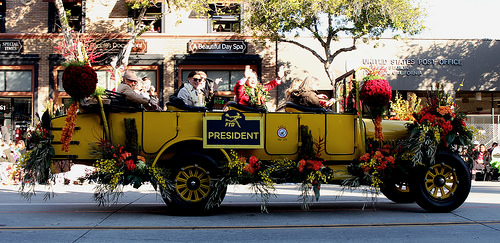

In [28]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

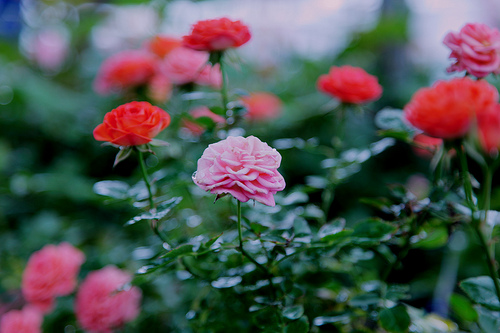

In [29]:
PIL.Image.open(str(roses[1]))

And some tulips:

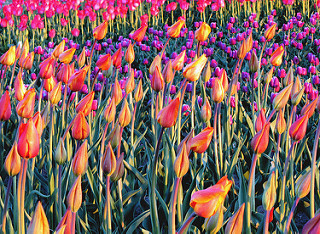

In [30]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

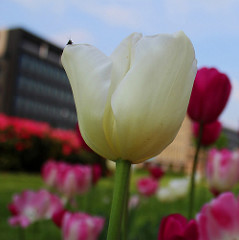

In [31]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [35]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

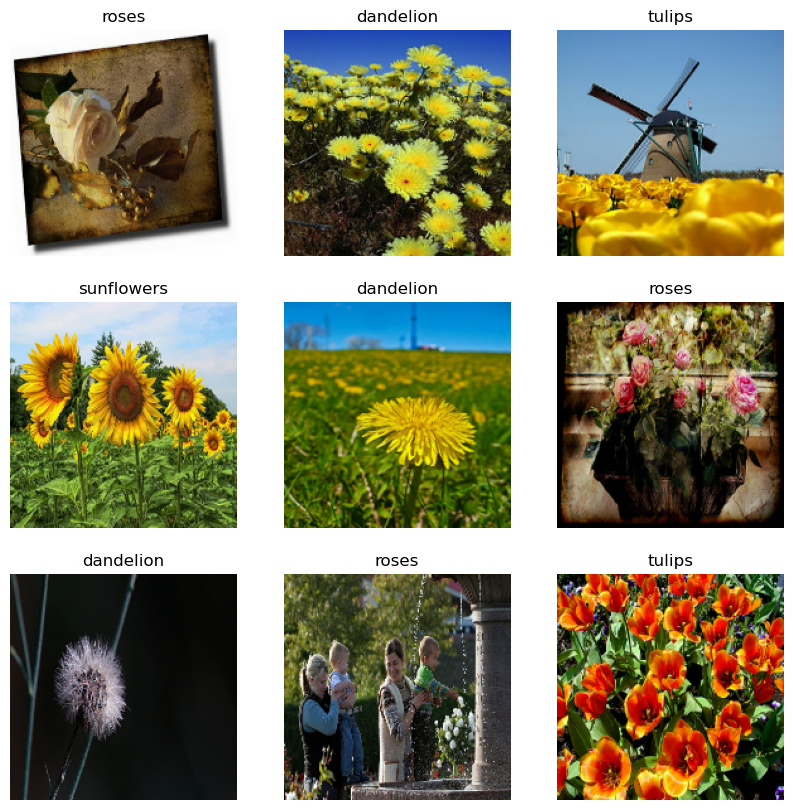

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [37]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [39]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [41]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [44]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
44/92 [=============>................] - ETA: 14s - loss: 1.4606 - accuracy: 0.3913

KeyboardInterrupt: 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

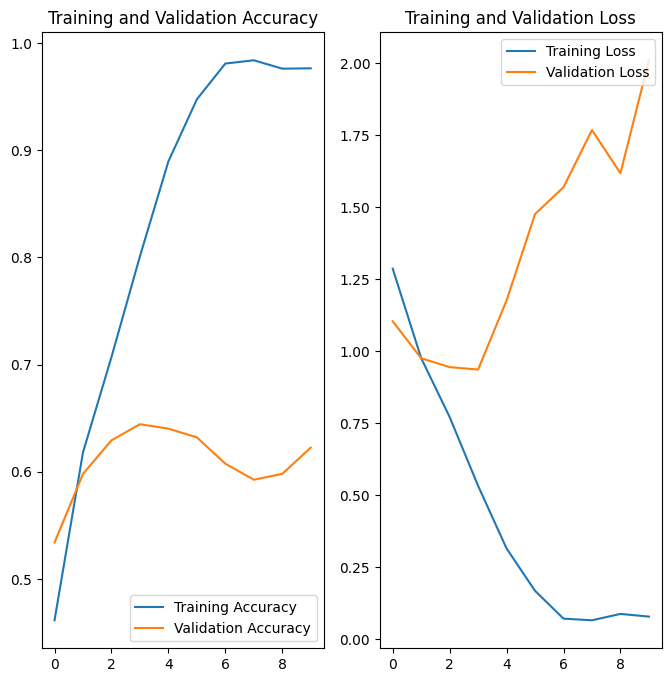

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

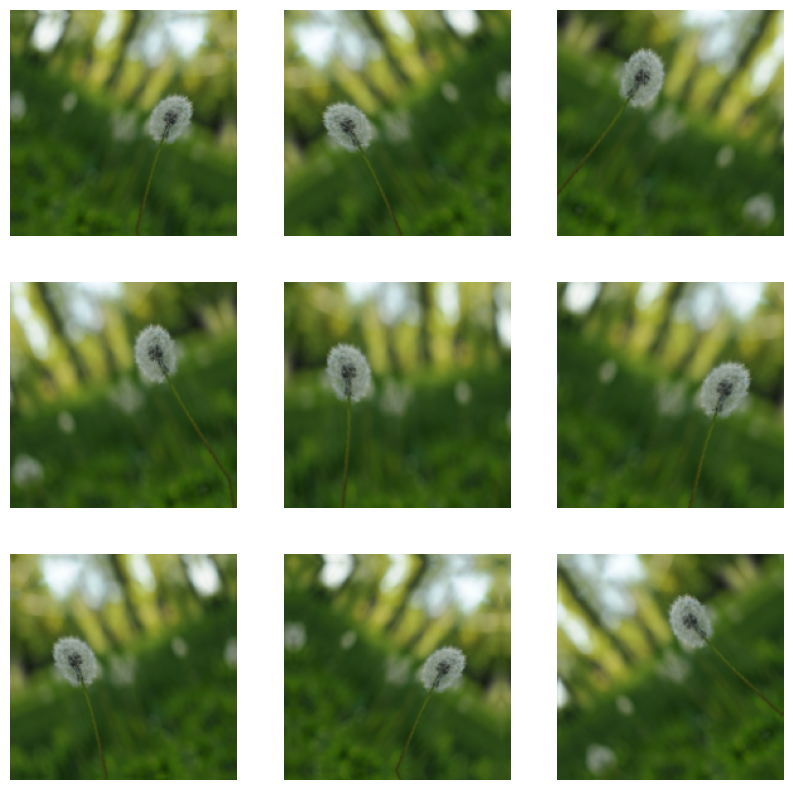

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-12-14 02:28:00.777823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



 1/92 [..............................] - ETA: 5:55 - loss: 1.6468 - accuracy: 0.1562


 2/92 [..............................] - ETA: 7s - loss: 2.3106 - accuracy: 0.2031  


 3/92 [..............................] - ETA: 7s - loss: 2.2471 - accuracy: 0.1979


 4/92 [>.............................] - ETA: 7s - loss: 2.0995 - accuracy: 0.2422


 5/92 [>.............................] - ETA: 7s - loss: 2.0065 - accuracy: 0.2438


 6/92 [>.............................] - ETA: 7s - loss: 1.9359 - accuracy: 0.2396


 7/92 [=>............................] - ETA: 7s - loss: 1.8879 - accuracy: 0.2188


 8/92 [=>............................] - ETA: 7s - loss: 1.8480 - accuracy: 0.2148


 9/92 [=>............................] - ETA: 7s - loss: 1.8192 - accuracy: 0.2118


10/92 [==>...........................] - ETA: 7s - loss: 1.7917 - accuracy: 0.2250


11/92 [==>...........................] - ETA: 7s - loss: 1.7720 - accuracy: 0.2273


12/92 [==>...........................] - ETA: 6s - loss: 1.7534 - accuracy: 0.2344


13/92 [===>..........................] - ETA: 6s - loss: 1.7391 - accuracy: 0.2332


14/92 [===>..........................] - ETA: 6s - loss: 1.7247 - accuracy: 0.2321


15/92 [===>..........................] - ETA: 6s - loss: 1.7095 - accuracy: 0.2417


16/92 [====>.........................] - ETA: 6s - loss: 1.6947 - accuracy: 0.2559


17/92 [====>.........................] - ETA: 6s - loss: 1.6785 - accuracy: 0.2702


18/92 [====>.........................] - ETA: 6s - loss: 1.6613 - accuracy: 0.2830


19/92 [=====>........................] - ETA: 6s - loss: 1.6478 - accuracy: 0.2911


20/92 [=====>........................] - ETA: 6s - loss: 1.6351 - accuracy: 0.3016


21/92 [=====>........................] - ETA: 6s - loss: 1.6255 - accuracy: 0.2976


22/92 [======>.......................] - ETA: 6s - loss: 1.6214 - accuracy: 0.3011


23/92 [======>.......................] - ETA: 5s - loss: 1.6079 - accuracy: 0.3071


24/92 [======>.......................] - ETA: 5s - loss: 1.6018 - accuracy: 0.3047


25/92 [=======>......................] - ETA: 5s - loss: 1.5947 - accuracy: 0.3081


26/92 [=======>......................] - ETA: 5s - loss: 1.5901 - accuracy: 0.3119


27/92 [=======>......................] - ETA: 5s - loss: 1.5795 - accuracy: 0.3131


28/92 [========>.....................] - ETA: 5s - loss: 1.5670 - accuracy: 0.3232


29/92 [========>.....................] - ETA: 5s - loss: 1.5553 - accuracy: 0.3239


30/92 [========>.....................] - ETA: 5s - loss: 1.5441 - accuracy: 0.3246


31/92 [=========>....................] - ETA: 5s - loss: 1.5358 - accuracy: 0.3272


32/92 [=========>....................] - ETA: 5s - loss: 1.5245 - accuracy: 0.3327


33/92 [=========>....................] - ETA: 5s - loss: 1.5169 - accuracy: 0.3387


34/92 [==========>...................] - ETA: 4s - loss: 1.5051 - accuracy: 0.3454


35/92 [==========>...................] - ETA: 4s - loss: 1.4992 - accuracy: 0.3471


36/92 [==========>...................] - ETA: 4s - loss: 1.4865 - accuracy: 0.3505


37/92 [===========>..................] - ETA: 4s - loss: 1.4818 - accuracy: 0.3537


38/92 [===========>..................] - ETA: 4s - loss: 1.4758 - accuracy: 0.3560


39/92 [===========>..................] - ETA: 4s - loss: 1.4710 - accuracy: 0.3565


40/92 [============>.................] - ETA: 4s - loss: 1.4622 - accuracy: 0.3601


41/92 [============>.................] - ETA: 4s - loss: 1.4638 - accuracy: 0.3604


42/92 [============>.................] - ETA: 4s - loss: 1.4594 - accuracy: 0.3608


43/92 [=============>................] - ETA: 4s - loss: 1.4534 - accuracy: 0.3640


44/92 [=============>................] - ETA: 4s - loss: 1.4469 - accuracy: 0.3671


45/92 [=============>................] - ETA: 4s - loss: 1.4432 - accuracy: 0.3694


46/92 [==============>...............] - ETA: 3s - loss: 1.4359 - accuracy: 0.3750


47/92 [==============>...............] - ETA: 3s - loss: 1.4277 - accuracy: 0.3810


48/92 [==============>...............] - ETA: 3s - loss: 1.4176 - accuracy: 0.3874


49/92 [==============>...............] - ETA: 3s - loss: 1.4144 - accuracy: 0.3885


50/92 [===============>..............] - ETA: 3s - loss: 1.4064 - accuracy: 0.3907


51/92 [===============>..............] - ETA: 3s - loss: 1.4015 - accuracy: 0.3916


52/92 [===============>..............] - ETA: 3s - loss: 1.3962 - accuracy: 0.3925


53/92 [================>.............] - ETA: 3s - loss: 1.3914 - accuracy: 0.3940


54/92 [================>.............] - ETA: 3s - loss: 1.3816 - accuracy: 0.4000


55/92 [================>.............] - ETA: 3s - loss: 1.3783 - accuracy: 0.4024


56/92 [=================>............] - ETA: 3s - loss: 1.3696 - accuracy: 0.4058


57/92 [=================>............] - ETA: 2s - loss: 1.3661 - accuracy: 0.4058


58/92 [=================>............] - ETA: 2s - loss: 1.3691 - accuracy: 0.4048


59/92 [==================>...........] - ETA: 2s - loss: 1.3657 - accuracy: 0.4064


60/92 [==================>...........] - ETA: 2s - loss: 1.3646 - accuracy: 0.4079


61/92 [==================>...........] - ETA: 2s - loss: 1.3621 - accuracy: 0.4084


62/92 [===================>..........] - ETA: 2s - loss: 1.3585 - accuracy: 0.4104


63/92 [===================>..........] - ETA: 2s - loss: 1.3555 - accuracy: 0.4114


64/92 [===================>..........] - ETA: 2s - loss: 1.3489 - accuracy: 0.4132


65/92 [====================>.........] - ETA: 2s - loss: 1.3453 - accuracy: 0.4151


66/92 [====================>.........] - ETA: 2s - loss: 1.3445 - accuracy: 0.4144


67/92 [====================>.........] - ETA: 2s - loss: 1.3447 - accuracy: 0.4120


68/92 [=====================>........] - ETA: 2s - loss: 1.3411 - accuracy: 0.4137


69/92 [=====================>........] - ETA: 1s - loss: 1.3379 - accuracy: 0.4145


70/92 [=====================>........] - ETA: 1s - loss: 1.3356 - accuracy: 0.4162


71/92 [======================>.......] - ETA: 1s - loss: 1.3335 - accuracy: 0.4161


72/92 [======================>.......] - ETA: 1s - loss: 1.3318 - accuracy: 0.4168


73/92 [======================>.......] - ETA: 1s - loss: 1.3300 - accuracy: 0.4167


74/92 [=======================>......] - ETA: 1s - loss: 1.3273 - accuracy: 0.4182


75/92 [=======================>......] - ETA: 1s - loss: 1.3242 - accuracy: 0.4197


76/92 [=======================>......] - ETA: 1s - loss: 1.3217 - accuracy: 0.4208


77/92 [========================>.....] - ETA: 1s - loss: 1.3211 - accuracy: 0.4222


78/92 [========================>.....] - ETA: 1s - loss: 1.3171 - accuracy: 0.4240


79/92 [========================>.....] - ETA: 1s - loss: 1.3141 - accuracy: 0.4254


80/92 [=========================>....] - ETA: 1s - loss: 1.3167 - accuracy: 0.4255


81/92 [=========================>....] - ETA: 0s - loss: 1.3180 - accuracy: 0.4253


82/92 [=========================>....] - ETA: 0s - loss: 1.3164 - accuracy: 0.4262


83/92 [==========================>...] - ETA: 0s - loss: 1.3182 - accuracy: 0.4260


84/92 [==========================>...] - ETA: 0s - loss: 1.3141 - accuracy: 0.4291


85/92 [==========================>...] - ETA: 0s - loss: 1.3136 - accuracy: 0.4288


86/92 [===========================>..] - ETA: 0s - loss: 1.3136 - accuracy: 0.4282


87/92 [===========================>..] - ETA: 0s - loss: 1.3147 - accuracy: 0.4305


88/92 [===========================>..] - ETA: 0s - loss: 1.3114 - accuracy: 0.4320


89/92 [============================>.] - ETA: 0s - loss: 1.3087 - accuracy: 0.4335


90/92 [============================>.] - ETA: 0s - loss: 1.3076 - accuracy: 0.4335


91/92 [============================>.] - ETA: 0s - loss: 1.3051 - accuracy: 0.4356


92/92 [==============================] - ETA: 0s - loss: 1.3027 - accuracy: 0.4373


92/92 [==============================] - 12s 89ms/step - loss: 1.3027 - accuracy: 0.4373 - val_loss: 1.0682 - val_accuracy: 0.5668


Epoch 2/15



 1/92 [..............................] - ETA: 8s - loss: 1.1005 - accuracy: 0.6562


 2/92 [..............................] - ETA: 8s - loss: 1.0680 - accuracy: 0.6250


 3/92 [..............................] - ETA: 7s - loss: 1.1177 - accuracy: 0.5625


 4/92 [>.............................] - ETA: 7s - loss: 1.0856 - accuracy: 0.5625


 5/92 [>.............................] - ETA: 7s - loss: 1.0852 - accuracy: 0.5750


 6/92 [>.............................] - ETA: 7s - loss: 1.0604 - accuracy: 0.5781


 7/92 [=>............................] - ETA: 7s - loss: 1.1107 - accuracy: 0.5536


 8/92 [=>............................] - ETA: 7s - loss: 1.0863 - accuracy: 0.5742


 9/92 [=>............................] - ETA: 7s - loss: 1.0850 - accuracy: 0.5799


10/92 [==>...........................] - ETA: 7s - loss: 1.0898 - accuracy: 0.5719


11/92 [==>...........................] - ETA: 7s - loss: 1.0899 - accuracy: 0.5710


12/92 [==>...........................] - ETA: 6s - loss: 1.0769 - accuracy: 0.5755


13/92 [===>..........................] - ETA: 6s - loss: 1.0732 - accuracy: 0.5745


14/92 [===>..........................] - ETA: 6s - loss: 1.0862 - accuracy: 0.5670


15/92 [===>..........................] - ETA: 6s - loss: 1.0937 - accuracy: 0.5625


16/92 [====>.........................] - ETA: 6s - loss: 1.0910 - accuracy: 0.5645


17/92 [====>.........................] - ETA: 6s - loss: 1.0787 - accuracy: 0.5662


18/92 [====>.........................] - ETA: 6s - loss: 1.0843 - accuracy: 0.5573


19/92 [=====>........................] - ETA: 6s - loss: 1.0968 - accuracy: 0.5543


20/92 [=====>........................] - ETA: 6s - loss: 1.0973 - accuracy: 0.5531


21/92 [=====>........................] - ETA: 6s - loss: 1.0944 - accuracy: 0.5595


22/92 [======>.......................] - ETA: 6s - loss: 1.0894 - accuracy: 0.5625


23/92 [======>.......................] - ETA: 5s - loss: 1.0859 - accuracy: 0.5693


24/92 [======>.......................] - ETA: 5s - loss: 1.1041 - accuracy: 0.5742


25/92 [=======>......................] - ETA: 5s - loss: 1.1062 - accuracy: 0.5738


26/92 [=======>......................] - ETA: 5s - loss: 1.0997 - accuracy: 0.5769


27/92 [=======>......................] - ETA: 5s - loss: 1.0949 - accuracy: 0.5764


28/92 [========>.....................] - ETA: 5s - loss: 1.1003 - accuracy: 0.5725


29/92 [========>.....................] - ETA: 5s - loss: 1.1044 - accuracy: 0.5668


30/92 [========>.....................] - ETA: 5s - loss: 1.1125 - accuracy: 0.5646


31/92 [=========>....................] - ETA: 5s - loss: 1.1085 - accuracy: 0.5645


32/92 [=========>....................] - ETA: 5s - loss: 1.1124 - accuracy: 0.5635


33/92 [=========>....................] - ETA: 5s - loss: 1.1144 - accuracy: 0.5672


34/92 [==========>...................] - ETA: 4s - loss: 1.1111 - accuracy: 0.5708


35/92 [==========>...................] - ETA: 4s - loss: 1.1075 - accuracy: 0.5723


36/92 [==========>...................] - ETA: 4s - loss: 1.1030 - accuracy: 0.5729


37/92 [===========>..................] - ETA: 4s - loss: 1.1035 - accuracy: 0.5743


38/92 [===========>..................] - ETA: 4s - loss: 1.1069 - accuracy: 0.5765


39/92 [===========>..................] - ETA: 4s - loss: 1.1053 - accuracy: 0.5753


40/92 [============>.................] - ETA: 4s - loss: 1.1103 - accuracy: 0.5688


41/92 [============>.................] - ETA: 4s - loss: 1.1109 - accuracy: 0.5686


42/92 [============>.................] - ETA: 4s - loss: 1.1093 - accuracy: 0.5685


43/92 [=============>................] - ETA: 4s - loss: 1.1109 - accuracy: 0.5661


44/92 [=============>................] - ETA: 4s - loss: 1.1129 - accuracy: 0.5632


45/92 [=============>................] - ETA: 4s - loss: 1.1166 - accuracy: 0.5618


46/92 [==============>...............] - ETA: 3s - loss: 1.1154 - accuracy: 0.5618


47/92 [==============>...............] - ETA: 3s - loss: 1.1121 - accuracy: 0.5632


48/92 [==============>...............] - ETA: 3s - loss: 1.1083 - accuracy: 0.5664


49/92 [==============>...............] - ETA: 3s - loss: 1.1060 - accuracy: 0.5657


50/92 [===============>..............] - ETA: 3s - loss: 1.1070 - accuracy: 0.5638


51/92 [===============>..............] - ETA: 3s - loss: 1.1068 - accuracy: 0.5613


52/92 [===============>..............] - ETA: 3s - loss: 1.1047 - accuracy: 0.5595


53/92 [================>.............] - ETA: 3s - loss: 1.1002 - accuracy: 0.5631


54/92 [================>.............] - ETA: 3s - loss: 1.0993 - accuracy: 0.5648


55/92 [================>.............] - ETA: 3s - loss: 1.0975 - accuracy: 0.5653


56/92 [=================>............] - ETA: 3s - loss: 1.0956 - accuracy: 0.5681


57/92 [=================>............] - ETA: 3s - loss: 1.0957 - accuracy: 0.5696


58/92 [=================>............] - ETA: 2s - loss: 1.0960 - accuracy: 0.5690


59/92 [==================>...........] - ETA: 2s - loss: 1.0894 - accuracy: 0.5720


60/92 [==================>...........] - ETA: 2s - loss: 1.0884 - accuracy: 0.5729


61/92 [==================>...........] - ETA: 2s - loss: 1.0927 - accuracy: 0.5702


62/92 [===================>..........] - ETA: 2s - loss: 1.0927 - accuracy: 0.5711


63/92 [===================>..........] - ETA: 2s - loss: 1.0891 - accuracy: 0.5719


64/92 [===================>..........] - ETA: 2s - loss: 1.0883 - accuracy: 0.5721


65/92 [====================>.........] - ETA: 2s - loss: 1.0847 - accuracy: 0.5729


66/92 [====================>.........] - ETA: 2s - loss: 1.0836 - accuracy: 0.5737


67/92 [====================>.........] - ETA: 2s - loss: 1.0825 - accuracy: 0.5749


68/92 [=====================>........] - ETA: 2s - loss: 1.0807 - accuracy: 0.5743


69/92 [=====================>........] - ETA: 1s - loss: 1.0804 - accuracy: 0.5736


70/92 [=====================>........] - ETA: 1s - loss: 1.0795 - accuracy: 0.5748


71/92 [======================>.......] - ETA: 1s - loss: 1.0834 - accuracy: 0.5733


72/92 [======================>.......] - ETA: 1s - loss: 1.0841 - accuracy: 0.5732


73/92 [======================>.......] - ETA: 1s - loss: 1.0814 - accuracy: 0.5743


74/92 [=======================>......] - ETA: 1s - loss: 1.0797 - accuracy: 0.5742


75/92 [=======================>......] - ETA: 1s - loss: 1.0773 - accuracy: 0.5748


76/92 [=======================>......] - ETA: 1s - loss: 1.0772 - accuracy: 0.5747


77/92 [========================>.....] - ETA: 1s - loss: 1.0743 - accuracy: 0.5761


78/92 [========================>.....] - ETA: 1s - loss: 1.0721 - accuracy: 0.5764


79/92 [========================>.....] - ETA: 1s - loss: 1.0717 - accuracy: 0.5774


80/92 [=========================>....] - ETA: 1s - loss: 1.0699 - accuracy: 0.5792


81/92 [=========================>....] - ETA: 0s - loss: 1.0690 - accuracy: 0.5786


82/92 [=========================>....] - ETA: 0s - loss: 1.0675 - accuracy: 0.5803


83/92 [==========================>...] - ETA: 0s - loss: 1.0656 - accuracy: 0.5819


84/92 [==========================>...] - ETA: 0s - loss: 1.0641 - accuracy: 0.5836


85/92 [==========================>...] - ETA: 0s - loss: 1.0626 - accuracy: 0.5837


86/92 [===========================>..] - ETA: 0s - loss: 1.0601 - accuracy: 0.5842


87/92 [===========================>..] - ETA: 0s - loss: 1.0625 - accuracy: 0.5836


88/92 [===========================>..] - ETA: 0s - loss: 1.0608 - accuracy: 0.5844


89/92 [============================>.] - ETA: 0s - loss: 1.0617 - accuracy: 0.5838


90/92 [============================>.] - ETA: 0s - loss: 1.0620 - accuracy: 0.5832


91/92 [============================>.] - ETA: 0s - loss: 1.0645 - accuracy: 0.5809


92/92 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5800


92/92 [==============================] - 8s 88ms/step - loss: 1.0648 - accuracy: 0.5800 - val_loss: 1.0003 - val_accuracy: 0.5899


Epoch 3/15



 1/92 [..............................] - ETA: 8s - loss: 0.8514 - accuracy: 0.7188


 2/92 [..............................] - ETA: 7s - loss: 0.9371 - accuracy: 0.6875


 3/92 [..............................] - ETA: 7s - loss: 0.9073 - accuracy: 0.7083


 4/92 [>.............................] - ETA: 7s - loss: 0.9302 - accuracy: 0.6875


 5/92 [>.............................] - ETA: 7s - loss: 0.9427 - accuracy: 0.6750


 6/92 [>.............................] - ETA: 7s - loss: 1.0010 - accuracy: 0.6406


 7/92 [=>............................] - ETA: 7s - loss: 0.9880 - accuracy: 0.6384


 8/92 [=>............................] - ETA: 7s - loss: 1.0084 - accuracy: 0.6367


 9/92 [=>............................] - ETA: 7s - loss: 1.0102 - accuracy: 0.6424


10/92 [==>...........................] - ETA: 7s - loss: 0.9900 - accuracy: 0.6406


11/92 [==>...........................] - ETA: 7s - loss: 1.0032 - accuracy: 0.6250


12/92 [==>...........................] - ETA: 6s - loss: 1.0081 - accuracy: 0.6250


13/92 [===>..........................] - ETA: 6s - loss: 1.0079 - accuracy: 0.6178


14/92 [===>..........................] - ETA: 6s - loss: 1.0274 - accuracy: 0.6094


15/92 [===>..........................] - ETA: 6s - loss: 1.0215 - accuracy: 0.6102


16/92 [====>.........................] - ETA: 6s - loss: 1.0447 - accuracy: 0.5913


17/92 [====>.........................] - ETA: 6s - loss: 1.0351 - accuracy: 0.5914


18/92 [====>.........................] - ETA: 6s - loss: 1.0262 - accuracy: 0.5951


19/92 [=====>........................] - ETA: 6s - loss: 1.0117 - accuracy: 0.6017


20/92 [=====>........................] - ETA: 6s - loss: 1.0080 - accuracy: 0.6092


21/92 [=====>........................] - ETA: 6s - loss: 1.0031 - accuracy: 0.6145


22/92 [======>.......................] - ETA: 6s - loss: 0.9959 - accuracy: 0.6178


23/92 [======>.......................] - ETA: 5s - loss: 0.9890 - accuracy: 0.6195


24/92 [======>.......................] - ETA: 5s - loss: 0.9951 - accuracy: 0.6184


25/92 [=======>......................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6250


26/92 [=======>......................] - ETA: 5s - loss: 0.9824 - accuracy: 0.6226


27/92 [=======>......................] - ETA: 5s - loss: 0.9822 - accuracy: 0.6227


28/92 [========>.....................] - ETA: 5s - loss: 0.9836 - accuracy: 0.6205


29/92 [========>.....................] - ETA: 5s - loss: 0.9829 - accuracy: 0.6217


30/92 [========>.....................] - ETA: 5s - loss: 0.9792 - accuracy: 0.6229


31/92 [=========>....................] - ETA: 5s - loss: 0.9787 - accuracy: 0.6220


32/92 [=========>....................] - ETA: 5s - loss: 0.9794 - accuracy: 0.6201


33/92 [=========>....................] - ETA: 5s - loss: 0.9897 - accuracy: 0.6145


34/92 [==========>...................] - ETA: 5s - loss: 0.9830 - accuracy: 0.6157


35/92 [==========>...................] - ETA: 4s - loss: 0.9817 - accuracy: 0.6160


36/92 [==========>...................] - ETA: 4s - loss: 0.9869 - accuracy: 0.6119


37/92 [===========>..................] - ETA: 4s - loss: 0.9864 - accuracy: 0.6114


38/92 [===========>..................] - ETA: 4s - loss: 0.9872 - accuracy: 0.6151


39/92 [===========>..................] - ETA: 4s - loss: 0.9822 - accuracy: 0.6177


40/92 [============>.................] - ETA: 4s - loss: 0.9797 - accuracy: 0.6203


41/92 [============>.................] - ETA: 4s - loss: 0.9767 - accuracy: 0.6189


42/92 [============>.................] - ETA: 4s - loss: 0.9772 - accuracy: 0.6160


43/92 [=============>................] - ETA: 4s - loss: 0.9772 - accuracy: 0.6133


44/92 [=============>................] - ETA: 4s - loss: 0.9734 - accuracy: 0.6143


45/92 [=============>................] - ETA: 4s - loss: 0.9717 - accuracy: 0.6131


46/92 [==============>...............] - ETA: 4s - loss: 0.9677 - accuracy: 0.6141


47/92 [==============>...............] - ETA: 3s - loss: 0.9703 - accuracy: 0.6136


48/92 [==============>...............] - ETA: 3s - loss: 0.9695 - accuracy: 0.6152


49/92 [==============>...............] - ETA: 3s - loss: 0.9657 - accuracy: 0.6186


50/92 [===============>..............] - ETA: 3s - loss: 0.9636 - accuracy: 0.6193


51/92 [===============>..............] - ETA: 3s - loss: 0.9627 - accuracy: 0.6201


52/92 [===============>..............] - ETA: 3s - loss: 0.9604 - accuracy: 0.6226


53/92 [================>.............] - ETA: 3s - loss: 0.9638 - accuracy: 0.6214


54/92 [================>.............] - ETA: 3s - loss: 0.9606 - accuracy: 0.6209


55/92 [================>.............] - ETA: 3s - loss: 0.9587 - accuracy: 0.6210


56/92 [=================>............] - ETA: 3s - loss: 0.9594 - accuracy: 0.6200


57/92 [=================>............] - ETA: 3s - loss: 0.9606 - accuracy: 0.6206


58/92 [=================>............] - ETA: 2s - loss: 0.9573 - accuracy: 0.6212


59/92 [==================>...........] - ETA: 2s - loss: 0.9543 - accuracy: 0.6229


60/92 [==================>...........] - ETA: 2s - loss: 0.9533 - accuracy: 0.6224


61/92 [==================>...........] - ETA: 2s - loss: 0.9465 - accuracy: 0.6255


62/92 [===================>..........] - ETA: 2s - loss: 0.9446 - accuracy: 0.6250


63/92 [===================>..........] - ETA: 2s - loss: 0.9414 - accuracy: 0.6270


64/92 [===================>..........] - ETA: 2s - loss: 0.9423 - accuracy: 0.6265


65/92 [====================>.........] - ETA: 2s - loss: 0.9406 - accuracy: 0.6284


66/92 [====================>.........] - ETA: 2s - loss: 0.9400 - accuracy: 0.6274


67/92 [====================>.........] - ETA: 2s - loss: 0.9382 - accuracy: 0.6273


68/92 [=====================>........] - ETA: 2s - loss: 0.9344 - accuracy: 0.6296


69/92 [=====================>........] - ETA: 2s - loss: 0.9314 - accuracy: 0.6309


70/92 [=====================>........] - ETA: 1s - loss: 0.9364 - accuracy: 0.6290


71/92 [======================>.......] - ETA: 1s - loss: 0.9401 - accuracy: 0.6281


72/92 [======================>.......] - ETA: 1s - loss: 0.9429 - accuracy: 0.6272


73/92 [======================>.......] - ETA: 1s - loss: 0.9430 - accuracy: 0.6276


74/92 [=======================>......] - ETA: 1s - loss: 0.9404 - accuracy: 0.6284


75/92 [=======================>......] - ETA: 1s - loss: 0.9430 - accuracy: 0.6271


76/92 [=======================>......] - ETA: 1s - loss: 0.9435 - accuracy: 0.6267


77/92 [========================>.....] - ETA: 1s - loss: 0.9472 - accuracy: 0.6258


78/92 [========================>.....] - ETA: 1s - loss: 0.9490 - accuracy: 0.6238


79/92 [========================>.....] - ETA: 1s - loss: 0.9496 - accuracy: 0.6242


80/92 [=========================>....] - ETA: 1s - loss: 0.9496 - accuracy: 0.6242


81/92 [=========================>....] - ETA: 0s - loss: 0.9496 - accuracy: 0.6242


82/92 [=========================>....] - ETA: 0s - loss: 0.9530 - accuracy: 0.6223


83/92 [==========================>...] - ETA: 0s - loss: 0.9541 - accuracy: 0.6216


84/92 [==========================>...] - ETA: 0s - loss: 0.9560 - accuracy: 0.6213


85/92 [==========================>...] - ETA: 0s - loss: 0.9583 - accuracy: 0.6198


86/92 [===========================>..] - ETA: 0s - loss: 0.9584 - accuracy: 0.6192


87/92 [===========================>..] - ETA: 0s - loss: 0.9576 - accuracy: 0.6200


88/92 [===========================>..] - ETA: 0s - loss: 0.9581 - accuracy: 0.6200


89/92 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.6197


90/92 [============================>.] - ETA: 0s - loss: 0.9540 - accuracy: 0.6205


91/92 [============================>.] - ETA: 0s - loss: 0.9530 - accuracy: 0.6209


92/92 [==============================] - ETA: 0s - loss: 0.9541 - accuracy: 0.6202


92/92 [==============================] - 8s 89ms/step - loss: 0.9541 - accuracy: 0.6202 - val_loss: 0.9559 - val_accuracy: 0.6335


Epoch 4/15



 1/92 [..............................] - ETA: 7s - loss: 0.9393 - accuracy: 0.6875


 2/92 [..............................] - ETA: 7s - loss: 1.0272 - accuracy: 0.5938


 3/92 [..............................] - ETA: 7s - loss: 1.0732 - accuracy: 0.5938


 4/92 [>.............................] - ETA: 7s - loss: 1.0097 - accuracy: 0.6250


 5/92 [>.............................] - ETA: 7s - loss: 0.9490 - accuracy: 0.6500


 6/92 [>.............................] - ETA: 7s - loss: 0.9782 - accuracy: 0.6510


 7/92 [=>............................] - ETA: 7s - loss: 0.9680 - accuracy: 0.6473


 8/92 [=>............................] - ETA: 7s - loss: 0.9354 - accuracy: 0.6562


 9/92 [=>............................] - ETA: 7s - loss: 0.9151 - accuracy: 0.6667


10/92 [==>...........................] - ETA: 7s - loss: 0.9155 - accuracy: 0.6594


11/92 [==>...........................] - ETA: 7s - loss: 0.9132 - accuracy: 0.6506


12/92 [==>...........................] - ETA: 6s - loss: 0.9107 - accuracy: 0.6484


13/92 [===>..........................] - ETA: 6s - loss: 0.9069 - accuracy: 0.6514


14/92 [===>..........................] - ETA: 6s - loss: 0.9150 - accuracy: 0.6496


15/92 [===>..........................] - ETA: 6s - loss: 0.9029 - accuracy: 0.6562


16/92 [====>.........................] - ETA: 6s - loss: 0.9049 - accuracy: 0.6582


17/92 [====>.........................] - ETA: 6s - loss: 0.9189 - accuracy: 0.6507


18/92 [====>.........................] - ETA: 6s - loss: 0.9116 - accuracy: 0.6528


19/92 [=====>........................] - ETA: 6s - loss: 0.9300 - accuracy: 0.6382


20/92 [=====>........................] - ETA: 6s - loss: 0.9260 - accuracy: 0.6438


21/92 [=====>........................] - ETA: 6s - loss: 0.9254 - accuracy: 0.6429


22/92 [======>.......................] - ETA: 6s - loss: 0.9219 - accuracy: 0.6463


23/92 [======>.......................] - ETA: 6s - loss: 0.9160 - accuracy: 0.6481


24/92 [======>.......................] - ETA: 5s - loss: 0.9015 - accuracy: 0.6523


25/92 [=======>......................] - ETA: 5s - loss: 0.8975 - accuracy: 0.6538


26/92 [=======>......................] - ETA: 5s - loss: 0.8965 - accuracy: 0.6562


27/92 [=======>......................] - ETA: 5s - loss: 0.9025 - accuracy: 0.6551


28/92 [========>.....................] - ETA: 5s - loss: 0.9052 - accuracy: 0.6529


29/92 [========>.....................] - ETA: 5s - loss: 0.9064 - accuracy: 0.6541


30/92 [========>.....................] - ETA: 5s - loss: 0.9068 - accuracy: 0.6531


31/92 [=========>....................] - ETA: 5s - loss: 0.9042 - accuracy: 0.6512


32/92 [=========>....................] - ETA: 5s - loss: 0.8990 - accuracy: 0.6533


33/92 [=========>....................] - ETA: 5s - loss: 0.8950 - accuracy: 0.6544


34/92 [==========>...................] - ETA: 5s - loss: 0.8931 - accuracy: 0.6544


35/92 [==========>...................] - ETA: 4s - loss: 0.8873 - accuracy: 0.6554


36/92 [==========>...................] - ETA: 4s - loss: 0.8820 - accuracy: 0.6554


37/92 [===========>..................] - ETA: 4s - loss: 0.8793 - accuracy: 0.6554


38/92 [===========>..................] - ETA: 4s - loss: 0.8761 - accuracy: 0.6562


39/92 [===========>..................] - ETA: 4s - loss: 0.8771 - accuracy: 0.6579


40/92 [============>.................] - ETA: 4s - loss: 0.8877 - accuracy: 0.6516


41/92 [============>.................] - ETA: 4s - loss: 0.8934 - accuracy: 0.6509


42/92 [============>.................] - ETA: 4s - loss: 0.8948 - accuracy: 0.6518


43/92 [=============>................] - ETA: 4s - loss: 0.8936 - accuracy: 0.6519


44/92 [=============>................] - ETA: 4s - loss: 0.8950 - accuracy: 0.6527


45/92 [=============>................] - ETA: 4s - loss: 0.8946 - accuracy: 0.6521


46/92 [==============>...............] - ETA: 4s - loss: 0.8929 - accuracy: 0.6542


47/92 [==============>...............] - ETA: 3s - loss: 0.8910 - accuracy: 0.6556


48/92 [==============>...............] - ETA: 3s - loss: 0.8899 - accuracy: 0.6556


49/92 [==============>...............] - ETA: 3s - loss: 0.8877 - accuracy: 0.6562


50/92 [===============>..............] - ETA: 3s - loss: 0.8865 - accuracy: 0.6569


51/92 [===============>..............] - ETA: 3s - loss: 0.8831 - accuracy: 0.6581


52/92 [===============>..............] - ETA: 3s - loss: 0.8832 - accuracy: 0.6581


53/92 [================>.............] - ETA: 3s - loss: 0.8778 - accuracy: 0.6604


54/92 [================>.............] - ETA: 3s - loss: 0.8805 - accuracy: 0.6586


55/92 [================>.............] - ETA: 3s - loss: 0.8795 - accuracy: 0.6591


56/92 [=================>............] - ETA: 3s - loss: 0.8794 - accuracy: 0.6585


57/92 [=================>............] - ETA: 3s - loss: 0.8773 - accuracy: 0.6579


58/92 [=================>............] - ETA: 2s - loss: 0.8778 - accuracy: 0.6579


59/92 [==================>...........] - ETA: 2s - loss: 0.8843 - accuracy: 0.6557


60/92 [==================>...........] - ETA: 2s - loss: 0.8802 - accuracy: 0.6573


61/92 [==================>...........] - ETA: 2s - loss: 0.8799 - accuracy: 0.6568


62/92 [===================>..........] - ETA: 2s - loss: 0.8767 - accuracy: 0.6598


63/92 [===================>..........] - ETA: 2s - loss: 0.8792 - accuracy: 0.6592


64/92 [===================>..........] - ETA: 2s - loss: 0.8791 - accuracy: 0.6592


65/92 [====================>.........] - ETA: 2s - loss: 0.8792 - accuracy: 0.6582


66/92 [====================>.........] - ETA: 2s - loss: 0.8762 - accuracy: 0.6591


67/92 [====================>.........] - ETA: 2s - loss: 0.8761 - accuracy: 0.6600


68/92 [=====================>........] - ETA: 2s - loss: 0.8763 - accuracy: 0.6595


69/92 [=====================>........] - ETA: 2s - loss: 0.8764 - accuracy: 0.6590


70/92 [=====================>........] - ETA: 1s - loss: 0.8766 - accuracy: 0.6582


71/92 [======================>.......] - ETA: 1s - loss: 0.8751 - accuracy: 0.6586


72/92 [======================>.......] - ETA: 1s - loss: 0.8740 - accuracy: 0.6585


73/92 [======================>.......] - ETA: 1s - loss: 0.8746 - accuracy: 0.6581


74/92 [=======================>......] - ETA: 1s - loss: 0.8739 - accuracy: 0.6576


75/92 [=======================>......] - ETA: 1s - loss: 0.8742 - accuracy: 0.6580


76/92 [=======================>......] - ETA: 1s - loss: 0.8760 - accuracy: 0.6572


77/92 [========================>.....] - ETA: 1s - loss: 0.8758 - accuracy: 0.6572


78/92 [========================>.....] - ETA: 1s - loss: 0.8761 - accuracy: 0.6568


79/92 [========================>.....] - ETA: 1s - loss: 0.8737 - accuracy: 0.6583


80/92 [=========================>....] - ETA: 1s - loss: 0.8719 - accuracy: 0.6591


81/92 [=========================>....] - ETA: 0s - loss: 0.8712 - accuracy: 0.6591


82/92 [=========================>....] - ETA: 0s - loss: 0.8703 - accuracy: 0.6602


83/92 [==========================>...] - ETA: 0s - loss: 0.8693 - accuracy: 0.6605


84/92 [==========================>...] - ETA: 0s - loss: 0.8694 - accuracy: 0.6604


85/92 [==========================>...] - ETA: 0s - loss: 0.8679 - accuracy: 0.6600


86/92 [===========================>..] - ETA: 0s - loss: 0.8655 - accuracy: 0.6614


87/92 [===========================>..] - ETA: 0s - loss: 0.8666 - accuracy: 0.6614


88/92 [===========================>..] - ETA: 0s - loss: 0.8639 - accuracy: 0.6624


89/92 [============================>.] - ETA: 0s - loss: 0.8640 - accuracy: 0.6620


90/92 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.6623


91/92 [============================>.] - ETA: 0s - loss: 0.8626 - accuracy: 0.6629


92/92 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.6604


92/92 [==============================] - 8s 89ms/step - loss: 0.8669 - accuracy: 0.6604 - val_loss: 0.8564 - val_accuracy: 0.6703


Epoch 5/15



 1/92 [..............................] - ETA: 8s - loss: 0.7565 - accuracy: 0.7188


 2/92 [..............................] - ETA: 7s - loss: 0.7311 - accuracy: 0.7500


 3/92 [..............................] - ETA: 7s - loss: 0.7735 - accuracy: 0.7292


 4/92 [>.............................] - ETA: 7s - loss: 0.8008 - accuracy: 0.7109


 5/92 [>.............................] - ETA: 7s - loss: 0.8005 - accuracy: 0.6938


 6/92 [>.............................] - ETA: 7s - loss: 0.7758 - accuracy: 0.6927


 7/92 [=>............................] - ETA: 7s - loss: 0.7556 - accuracy: 0.7054


 8/92 [=>............................] - ETA: 7s - loss: 0.7452 - accuracy: 0.7031


 9/92 [=>............................] - ETA: 7s - loss: 0.7642 - accuracy: 0.7014


10/92 [==>...........................] - ETA: 7s - loss: 0.7503 - accuracy: 0.7125


11/92 [==>...........................] - ETA: 7s - loss: 0.7505 - accuracy: 0.7102


12/92 [==>...........................] - ETA: 7s - loss: 0.7676 - accuracy: 0.7057


13/92 [===>..........................] - ETA: 6s - loss: 0.7799 - accuracy: 0.6995


14/92 [===>..........................] - ETA: 6s - loss: 0.7871 - accuracy: 0.6987


15/92 [===>..........................] - ETA: 6s - loss: 0.7910 - accuracy: 0.6917


16/92 [====>.........................] - ETA: 6s - loss: 0.7902 - accuracy: 0.6895


17/92 [====>.........................] - ETA: 6s - loss: 0.7875 - accuracy: 0.6930


18/92 [====>.........................] - ETA: 6s - loss: 0.7741 - accuracy: 0.6962


19/92 [=====>........................] - ETA: 6s - loss: 0.7756 - accuracy: 0.6990


20/92 [=====>........................] - ETA: 6s - loss: 0.7841 - accuracy: 0.6984


21/92 [=====>........................] - ETA: 6s - loss: 0.7860 - accuracy: 0.7009


22/92 [======>.......................] - ETA: 6s - loss: 0.7889 - accuracy: 0.6974


23/92 [======>.......................] - ETA: 6s - loss: 0.7840 - accuracy: 0.7024


24/92 [======>.......................] - ETA: 5s - loss: 0.7801 - accuracy: 0.7044


25/92 [=======>......................] - ETA: 5s - loss: 0.7816 - accuracy: 0.7033


26/92 [=======>......................] - ETA: 5s - loss: 0.7911 - accuracy: 0.6990


27/92 [=======>......................] - ETA: 5s - loss: 0.7941 - accuracy: 0.6998


28/92 [========>.....................] - ETA: 5s - loss: 0.8028 - accuracy: 0.6982


29/92 [========>.....................] - ETA: 5s - loss: 0.8111 - accuracy: 0.6946


30/92 [========>.....................] - ETA: 5s - loss: 0.8184 - accuracy: 0.6901


31/92 [=========>....................] - ETA: 5s - loss: 0.8161 - accuracy: 0.6911


32/92 [=========>....................] - ETA: 5s - loss: 0.8260 - accuracy: 0.6880


33/92 [=========>....................] - ETA: 5s - loss: 0.8271 - accuracy: 0.6870


34/92 [==========>...................] - ETA: 5s - loss: 0.8275 - accuracy: 0.6880


35/92 [==========>...................] - ETA: 4s - loss: 0.8333 - accuracy: 0.6888


36/92 [==========>...................] - ETA: 4s - loss: 0.8335 - accuracy: 0.6897


37/92 [===========>..................] - ETA: 4s - loss: 0.8288 - accuracy: 0.6947


38/92 [===========>..................] - ETA: 4s - loss: 0.8283 - accuracy: 0.6929


39/92 [===========>..................] - ETA: 4s - loss: 0.8293 - accuracy: 0.6895


40/92 [============>.................] - ETA: 4s - loss: 0.8275 - accuracy: 0.6895


41/92 [============>.................] - ETA: 4s - loss: 0.8256 - accuracy: 0.6887


42/92 [============>.................] - ETA: 4s - loss: 0.8192 - accuracy: 0.6901


43/92 [=============>................] - ETA: 4s - loss: 0.8180 - accuracy: 0.6908


44/92 [=============>................] - ETA: 4s - loss: 0.8161 - accuracy: 0.6921


45/92 [=============>................] - ETA: 4s - loss: 0.8149 - accuracy: 0.6913


46/92 [==============>...............] - ETA: 4s - loss: 0.8132 - accuracy: 0.6919


47/92 [==============>...............] - ETA: 3s - loss: 0.8143 - accuracy: 0.6918


48/92 [==============>...............] - ETA: 3s - loss: 0.8156 - accuracy: 0.6898


49/92 [==============>...............] - ETA: 3s - loss: 0.8164 - accuracy: 0.6891


50/92 [===============>..............] - ETA: 3s - loss: 0.8153 - accuracy: 0.6891


51/92 [===============>..............] - ETA: 3s - loss: 0.8169 - accuracy: 0.6878


52/92 [===============>..............] - ETA: 3s - loss: 0.8190 - accuracy: 0.6878


53/92 [================>.............] - ETA: 3s - loss: 0.8201 - accuracy: 0.6878


54/92 [================>.............] - ETA: 3s - loss: 0.8214 - accuracy: 0.6860


55/92 [================>.............] - ETA: 3s - loss: 0.8256 - accuracy: 0.6849


56/92 [=================>............] - ETA: 3s - loss: 0.8226 - accuracy: 0.6850


57/92 [=================>............] - ETA: 3s - loss: 0.8265 - accuracy: 0.6828


58/92 [=================>............] - ETA: 2s - loss: 0.8231 - accuracy: 0.6834


59/92 [==================>...........] - ETA: 2s - loss: 0.8204 - accuracy: 0.6840


60/92 [==================>...........] - ETA: 2s - loss: 0.8193 - accuracy: 0.6851


61/92 [==================>...........] - ETA: 2s - loss: 0.8238 - accuracy: 0.6831


62/92 [===================>..........] - ETA: 2s - loss: 0.8225 - accuracy: 0.6837


63/92 [===================>..........] - ETA: 2s - loss: 0.8222 - accuracy: 0.6838


64/92 [===================>..........] - ETA: 2s - loss: 0.8215 - accuracy: 0.6853


65/92 [====================>.........] - ETA: 2s - loss: 0.8240 - accuracy: 0.6853


66/92 [====================>.........] - ETA: 2s - loss: 0.8256 - accuracy: 0.6835


67/92 [====================>.........] - ETA: 2s - loss: 0.8227 - accuracy: 0.6859


68/92 [=====================>........] - ETA: 2s - loss: 0.8202 - accuracy: 0.6873


69/92 [=====================>........] - ETA: 2s - loss: 0.8212 - accuracy: 0.6873


70/92 [=====================>........] - ETA: 1s - loss: 0.8234 - accuracy: 0.6868


71/92 [======================>.......] - ETA: 1s - loss: 0.8273 - accuracy: 0.6860


72/92 [======================>.......] - ETA: 1s - loss: 0.8283 - accuracy: 0.6847


73/92 [======================>.......] - ETA: 1s - loss: 0.8314 - accuracy: 0.6834


74/92 [=======================>......] - ETA: 1s - loss: 0.8310 - accuracy: 0.6826


75/92 [=======================>......] - ETA: 1s - loss: 0.8306 - accuracy: 0.6839


76/92 [=======================>......] - ETA: 1s - loss: 0.8279 - accuracy: 0.6861


77/92 [========================>.....] - ETA: 1s - loss: 0.8309 - accuracy: 0.6840


78/92 [========================>.....] - ETA: 1s - loss: 0.8287 - accuracy: 0.6857


79/92 [========================>.....] - ETA: 1s - loss: 0.8269 - accuracy: 0.6861


80/92 [=========================>....] - ETA: 1s - loss: 0.8266 - accuracy: 0.6865


81/92 [=========================>....] - ETA: 0s - loss: 0.8254 - accuracy: 0.6861


82/92 [=========================>....] - ETA: 0s - loss: 0.8230 - accuracy: 0.6869


83/92 [==========================>...] - ETA: 0s - loss: 0.8258 - accuracy: 0.6862


84/92 [==========================>...] - ETA: 0s - loss: 0.8274 - accuracy: 0.6851


85/92 [==========================>...] - ETA: 0s - loss: 0.8245 - accuracy: 0.6855


86/92 [===========================>..] - ETA: 0s - loss: 0.8249 - accuracy: 0.6855


87/92 [===========================>..] - ETA: 0s - loss: 0.8241 - accuracy: 0.6852


88/92 [===========================>..] - ETA: 0s - loss: 0.8232 - accuracy: 0.6866


89/92 [============================>.] - ETA: 0s - loss: 0.8211 - accuracy: 0.6870


90/92 [============================>.] - ETA: 0s - loss: 0.8207 - accuracy: 0.6866


91/92 [============================>.] - ETA: 0s - loss: 0.8210 - accuracy: 0.6870


92/92 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.6870


92/92 [==============================] - 8s 90ms/step - loss: 0.8192 - accuracy: 0.6870 - val_loss: 0.8441 - val_accuracy: 0.6608


Epoch 6/15



 1/92 [..............................] - ETA: 7s - loss: 0.8166 - accuracy: 0.7500


 2/92 [..............................] - ETA: 7s - loss: 0.8180 - accuracy: 0.6562


 3/92 [..............................] - ETA: 7s - loss: 0.8018 - accuracy: 0.6354


 4/92 [>.............................] - ETA: 7s - loss: 0.7473 - accuracy: 0.6797


 5/92 [>.............................] - ETA: 7s - loss: 0.7492 - accuracy: 0.6875


 6/92 [>.............................] - ETA: 7s - loss: 0.7410 - accuracy: 0.6875


 7/92 [=>............................] - ETA: 7s - loss: 0.7268 - accuracy: 0.6964


 8/92 [=>............................] - ETA: 7s - loss: 0.7332 - accuracy: 0.6875


 9/92 [=>............................] - ETA: 7s - loss: 0.7149 - accuracy: 0.7014


10/92 [==>...........................] - ETA: 7s - loss: 0.7170 - accuracy: 0.7094


11/92 [==>...........................] - ETA: 6s - loss: 0.7247 - accuracy: 0.7074


12/92 [==>...........................] - ETA: 6s - loss: 0.7195 - accuracy: 0.7109


13/92 [===>..........................] - ETA: 6s - loss: 0.7359 - accuracy: 0.7115


14/92 [===>..........................] - ETA: 6s - loss: 0.7413 - accuracy: 0.7143


15/92 [===>..........................] - ETA: 6s - loss: 0.7461 - accuracy: 0.7125


16/92 [====>.........................] - ETA: 6s - loss: 0.7543 - accuracy: 0.7129


17/92 [====>.........................] - ETA: 6s - loss: 0.7481 - accuracy: 0.7169


18/92 [====>.........................] - ETA: 6s - loss: 0.7587 - accuracy: 0.7188


19/92 [=====>........................] - ETA: 6s - loss: 0.7465 - accuracy: 0.7253


20/92 [=====>........................] - ETA: 6s - loss: 0.7423 - accuracy: 0.7281


21/92 [=====>........................] - ETA: 6s - loss: 0.7375 - accuracy: 0.7321


22/92 [======>.......................] - ETA: 5s - loss: 0.7438 - accuracy: 0.7344


23/92 [======>.......................] - ETA: 5s - loss: 0.7347 - accuracy: 0.7364


24/92 [======>.......................] - ETA: 5s - loss: 0.7335 - accuracy: 0.7370


25/92 [=======>......................] - ETA: 5s - loss: 0.7286 - accuracy: 0.7362


26/92 [=======>......................] - ETA: 5s - loss: 0.7222 - accuracy: 0.7368


27/92 [=======>......................] - ETA: 5s - loss: 0.7292 - accuracy: 0.7338


28/92 [========>.....................] - ETA: 5s - loss: 0.7343 - accuracy: 0.7344


29/92 [========>.....................] - ETA: 5s - loss: 0.7340 - accuracy: 0.7349


30/92 [========>.....................] - ETA: 5s - loss: 0.7320 - accuracy: 0.7354


31/92 [=========>....................] - ETA: 5s - loss: 0.7247 - accuracy: 0.7389


32/92 [=========>....................] - ETA: 5s - loss: 0.7271 - accuracy: 0.7393


33/92 [=========>....................] - ETA: 5s - loss: 0.7304 - accuracy: 0.7348


34/92 [==========>...................] - ETA: 4s - loss: 0.7291 - accuracy: 0.7335


35/92 [==========>...................] - ETA: 4s - loss: 0.7337 - accuracy: 0.7312


36/92 [==========>...................] - ETA: 4s - loss: 0.7351 - accuracy: 0.7299


37/92 [===========>..................] - ETA: 4s - loss: 0.7401 - accuracy: 0.7287


38/92 [===========>..................] - ETA: 4s - loss: 0.7345 - accuracy: 0.7326


39/92 [===========>..................] - ETA: 4s - loss: 0.7303 - accuracy: 0.7347


40/92 [============>.................] - ETA: 4s - loss: 0.7348 - accuracy: 0.7319


41/92 [============>.................] - ETA: 4s - loss: 0.7373 - accuracy: 0.7285


42/92 [============>.................] - ETA: 4s - loss: 0.7325 - accuracy: 0.7298


43/92 [=============>................] - ETA: 4s - loss: 0.7337 - accuracy: 0.7288


44/92 [=============>................] - ETA: 4s - loss: 0.7362 - accuracy: 0.7279


45/92 [=============>................] - ETA: 3s - loss: 0.7369 - accuracy: 0.7277


46/92 [==============>...............] - ETA: 3s - loss: 0.7417 - accuracy: 0.7261


47/92 [==============>...............] - ETA: 3s - loss: 0.7382 - accuracy: 0.7273


48/92 [==============>...............] - ETA: 3s - loss: 0.7387 - accuracy: 0.7264


49/92 [==============>...............] - ETA: 3s - loss: 0.7382 - accuracy: 0.7263


50/92 [===============>..............] - ETA: 3s - loss: 0.7400 - accuracy: 0.7261


51/92 [===============>..............] - ETA: 3s - loss: 0.7422 - accuracy: 0.7241


52/92 [===============>..............] - ETA: 3s - loss: 0.7417 - accuracy: 0.7246


53/92 [================>.............] - ETA: 3s - loss: 0.7466 - accuracy: 0.7216


54/92 [================>.............] - ETA: 3s - loss: 0.7457 - accuracy: 0.7227


55/92 [================>.............] - ETA: 3s - loss: 0.7454 - accuracy: 0.7226


56/92 [=================>............] - ETA: 3s - loss: 0.7482 - accuracy: 0.7209


57/92 [=================>............] - ETA: 2s - loss: 0.7467 - accuracy: 0.7219


58/92 [=================>............] - ETA: 2s - loss: 0.7484 - accuracy: 0.7197


59/92 [==================>...........] - ETA: 2s - loss: 0.7473 - accuracy: 0.7197


60/92 [==================>...........] - ETA: 2s - loss: 0.7450 - accuracy: 0.7207


61/92 [==================>...........] - ETA: 2s - loss: 0.7468 - accuracy: 0.7202


62/92 [===================>..........] - ETA: 2s - loss: 0.7455 - accuracy: 0.7206


63/92 [===================>..........] - ETA: 2s - loss: 0.7433 - accuracy: 0.7211


64/92 [===================>..........] - ETA: 2s - loss: 0.7443 - accuracy: 0.7206


65/92 [====================>.........] - ETA: 2s - loss: 0.7431 - accuracy: 0.7220


66/92 [====================>.........] - ETA: 2s - loss: 0.7403 - accuracy: 0.7234


67/92 [====================>.........] - ETA: 2s - loss: 0.7379 - accuracy: 0.7238


68/92 [=====================>........] - ETA: 2s - loss: 0.7354 - accuracy: 0.7246


69/92 [=====================>........] - ETA: 1s - loss: 0.7332 - accuracy: 0.7264


70/92 [=====================>........] - ETA: 1s - loss: 0.7367 - accuracy: 0.7263


71/92 [======================>.......] - ETA: 1s - loss: 0.7349 - accuracy: 0.7270


72/92 [======================>.......] - ETA: 1s - loss: 0.7356 - accuracy: 0.7274


73/92 [======================>.......] - ETA: 1s - loss: 0.7382 - accuracy: 0.7281


74/92 [=======================>......] - ETA: 1s - loss: 0.7404 - accuracy: 0.7267


75/92 [=======================>......] - ETA: 1s - loss: 0.7423 - accuracy: 0.7253


76/92 [=======================>......] - ETA: 1s - loss: 0.7428 - accuracy: 0.7261


77/92 [========================>.....] - ETA: 1s - loss: 0.7416 - accuracy: 0.7272


78/92 [========================>.....] - ETA: 1s - loss: 0.7380 - accuracy: 0.7279


79/92 [========================>.....] - ETA: 1s - loss: 0.7409 - accuracy: 0.7266


80/92 [=========================>....] - ETA: 1s - loss: 0.7390 - accuracy: 0.7265


81/92 [=========================>....] - ETA: 0s - loss: 0.7406 - accuracy: 0.7248


82/92 [=========================>....] - ETA: 0s - loss: 0.7398 - accuracy: 0.7252


83/92 [==========================>...] - ETA: 0s - loss: 0.7387 - accuracy: 0.7251


84/92 [==========================>...] - ETA: 0s - loss: 0.7382 - accuracy: 0.7250


85/92 [==========================>...] - ETA: 0s - loss: 0.7369 - accuracy: 0.7257


86/92 [===========================>..] - ETA: 0s - loss: 0.7345 - accuracy: 0.7267


87/92 [===========================>..] - ETA: 0s - loss: 0.7328 - accuracy: 0.7280


88/92 [===========================>..] - ETA: 0s - loss: 0.7338 - accuracy: 0.7265


89/92 [============================>.] - ETA: 0s - loss: 0.7377 - accuracy: 0.7239


90/92 [============================>.] - ETA: 0s - loss: 0.7399 - accuracy: 0.7242


91/92 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.7242


92/92 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.7234


92/92 [==============================] - 8s 87ms/step - loss: 0.7406 - accuracy: 0.7234 - val_loss: 0.7743 - val_accuracy: 0.6894


Epoch 7/15



 1/92 [..............................] - ETA: 7s - loss: 0.8028 - accuracy: 0.6250


 2/92 [..............................] - ETA: 7s - loss: 0.7447 - accuracy: 0.6719


 3/92 [..............................] - ETA: 7s - loss: 0.6378 - accuracy: 0.7396


 4/92 [>.............................] - ETA: 7s - loss: 0.6174 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 7s - loss: 0.6432 - accuracy: 0.7375


 6/92 [>.............................] - ETA: 7s - loss: 0.6720 - accuracy: 0.7188


 7/92 [=>............................] - ETA: 7s - loss: 0.6688 - accuracy: 0.7188


 8/92 [=>............................] - ETA: 7s - loss: 0.6466 - accuracy: 0.7266


 9/92 [=>............................] - ETA: 7s - loss: 0.6389 - accuracy: 0.7257


10/92 [==>...........................] - ETA: 7s - loss: 0.6582 - accuracy: 0.7219


11/92 [==>...........................] - ETA: 6s - loss: 0.6549 - accuracy: 0.7273


12/92 [==>...........................] - ETA: 6s - loss: 0.6690 - accuracy: 0.7161


13/92 [===>..........................] - ETA: 6s - loss: 0.6669 - accuracy: 0.7212


14/92 [===>..........................] - ETA: 6s - loss: 0.6652 - accuracy: 0.7254


15/92 [===>..........................] - ETA: 6s - loss: 0.6602 - accuracy: 0.7292


16/92 [====>.........................] - ETA: 6s - loss: 0.6864 - accuracy: 0.7207


17/92 [====>.........................] - ETA: 6s - loss: 0.6954 - accuracy: 0.7243


18/92 [====>.........................] - ETA: 6s - loss: 0.6966 - accuracy: 0.7240


19/92 [=====>........................] - ETA: 6s - loss: 0.6858 - accuracy: 0.7303


20/92 [=====>........................] - ETA: 6s - loss: 0.6887 - accuracy: 0.7281


21/92 [=====>........................] - ETA: 6s - loss: 0.6914 - accuracy: 0.7277


22/92 [======>.......................] - ETA: 6s - loss: 0.6915 - accuracy: 0.7287


23/92 [======>.......................] - ETA: 6s - loss: 0.6934 - accuracy: 0.7269


24/92 [======>.......................] - ETA: 5s - loss: 0.7024 - accuracy: 0.7240


25/92 [=======>......................] - ETA: 5s - loss: 0.7017 - accuracy: 0.7237


26/92 [=======>......................] - ETA: 5s - loss: 0.7064 - accuracy: 0.7224


27/92 [=======>......................] - ETA: 5s - loss: 0.7090 - accuracy: 0.7245


28/92 [========>.....................] - ETA: 5s - loss: 0.7022 - accuracy: 0.7266


29/92 [========>.....................] - ETA: 5s - loss: 0.7005 - accuracy: 0.7263


30/92 [========>.....................] - ETA: 5s - loss: 0.6933 - accuracy: 0.7302


31/92 [=========>....................] - ETA: 5s - loss: 0.6899 - accuracy: 0.7319


32/92 [=========>....................] - ETA: 5s - loss: 0.6984 - accuracy: 0.7305


33/92 [=========>....................] - ETA: 5s - loss: 0.6995 - accuracy: 0.7301


34/92 [==========>...................] - ETA: 5s - loss: 0.7052 - accuracy: 0.7279


35/92 [==========>...................] - ETA: 4s - loss: 0.7054 - accuracy: 0.7259


36/92 [==========>...................] - ETA: 4s - loss: 0.7032 - accuracy: 0.7266


37/92 [===========>..................] - ETA: 4s - loss: 0.7041 - accuracy: 0.7264


38/92 [===========>..................] - ETA: 4s - loss: 0.7100 - accuracy: 0.7237


39/92 [===========>..................] - ETA: 4s - loss: 0.7090 - accuracy: 0.7242


40/92 [============>.................] - ETA: 4s - loss: 0.7095 - accuracy: 0.7233


41/92 [============>.................] - ETA: 4s - loss: 0.7094 - accuracy: 0.7224


42/92 [============>.................] - ETA: 4s - loss: 0.7150 - accuracy: 0.7193


43/92 [=============>................] - ETA: 4s - loss: 0.7151 - accuracy: 0.7186


44/92 [=============>................] - ETA: 4s - loss: 0.7120 - accuracy: 0.7200


45/92 [=============>................] - ETA: 4s - loss: 0.7136 - accuracy: 0.7193


46/92 [==============>...............] - ETA: 3s - loss: 0.7150 - accuracy: 0.7158


47/92 [==============>...............] - ETA: 3s - loss: 0.7104 - accuracy: 0.7172


48/92 [==============>...............] - ETA: 3s - loss: 0.7114 - accuracy: 0.7173


49/92 [==============>...............] - ETA: 3s - loss: 0.7112 - accuracy: 0.7179


50/92 [===============>..............] - ETA: 3s - loss: 0.7084 - accuracy: 0.7198


51/92 [===============>..............] - ETA: 3s - loss: 0.7031 - accuracy: 0.7229


52/92 [===============>..............] - ETA: 3s - loss: 0.7055 - accuracy: 0.7204


53/92 [================>.............] - ETA: 3s - loss: 0.7013 - accuracy: 0.7216


54/92 [================>.............] - ETA: 3s - loss: 0.7006 - accuracy: 0.7221


55/92 [================>.............] - ETA: 3s - loss: 0.7014 - accuracy: 0.7220


56/92 [=================>............] - ETA: 3s - loss: 0.7023 - accuracy: 0.7214


57/92 [=================>............] - ETA: 2s - loss: 0.6995 - accuracy: 0.7219


58/92 [=================>............] - ETA: 2s - loss: 0.6955 - accuracy: 0.7229


59/92 [==================>...........] - ETA: 2s - loss: 0.6937 - accuracy: 0.7250


60/92 [==================>...........] - ETA: 2s - loss: 0.6961 - accuracy: 0.7233


61/92 [==================>...........] - ETA: 2s - loss: 0.6967 - accuracy: 0.7243


62/92 [===================>..........] - ETA: 2s - loss: 0.6946 - accuracy: 0.7267


63/92 [===================>..........] - ETA: 2s - loss: 0.6933 - accuracy: 0.7271


64/92 [===================>..........] - ETA: 2s - loss: 0.6941 - accuracy: 0.7275


65/92 [====================>.........] - ETA: 2s - loss: 0.6962 - accuracy: 0.7273


66/92 [====================>.........] - ETA: 2s - loss: 0.6978 - accuracy: 0.7262


67/92 [====================>.........] - ETA: 2s - loss: 0.6970 - accuracy: 0.7261


68/92 [=====================>........] - ETA: 2s - loss: 0.6968 - accuracy: 0.7265


69/92 [=====================>........] - ETA: 1s - loss: 0.6924 - accuracy: 0.7286


70/92 [=====================>........] - ETA: 1s - loss: 0.6938 - accuracy: 0.7289


71/92 [======================>.......] - ETA: 1s - loss: 0.6894 - accuracy: 0.7310


72/92 [======================>.......] - ETA: 1s - loss: 0.6895 - accuracy: 0.7300


73/92 [======================>.......] - ETA: 1s - loss: 0.6894 - accuracy: 0.7294


74/92 [=======================>......] - ETA: 1s - loss: 0.6917 - accuracy: 0.7292


75/92 [=======================>......] - ETA: 1s - loss: 0.6928 - accuracy: 0.7287


76/92 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.7285


77/92 [========================>.....] - ETA: 1s - loss: 0.6924 - accuracy: 0.7288


78/92 [========================>.....] - ETA: 1s - loss: 0.6964 - accuracy: 0.7271


79/92 [========================>.....] - ETA: 1s - loss: 0.6984 - accuracy: 0.7258


80/92 [=========================>....] - ETA: 1s - loss: 0.6975 - accuracy: 0.7261


81/92 [=========================>....] - ETA: 0s - loss: 0.6991 - accuracy: 0.7260


82/92 [=========================>....] - ETA: 0s - loss: 0.6992 - accuracy: 0.7263


83/92 [==========================>...] - ETA: 0s - loss: 0.6987 - accuracy: 0.7258


84/92 [==========================>...] - ETA: 0s - loss: 0.7003 - accuracy: 0.7239


85/92 [==========================>...] - ETA: 0s - loss: 0.6988 - accuracy: 0.7253


86/92 [===========================>..] - ETA: 0s - loss: 0.6988 - accuracy: 0.7259


87/92 [===========================>..] - ETA: 0s - loss: 0.7025 - accuracy: 0.7259


88/92 [===========================>..] - ETA: 0s - loss: 0.7039 - accuracy: 0.7258


89/92 [============================>.] - ETA: 0s - loss: 0.7021 - accuracy: 0.7261


90/92 [============================>.] - ETA: 0s - loss: 0.7037 - accuracy: 0.7249


91/92 [============================>.] - ETA: 0s - loss: 0.7043 - accuracy: 0.7249


92/92 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.7245


92/92 [==============================] - 8s 88ms/step - loss: 0.7047 - accuracy: 0.7245 - val_loss: 0.7848 - val_accuracy: 0.6935


Epoch 8/15



 1/92 [..............................] - ETA: 7s - loss: 0.5867 - accuracy: 0.7188


 2/92 [..............................] - ETA: 7s - loss: 0.5250 - accuracy: 0.7812


 3/92 [..............................] - ETA: 7s - loss: 0.5197 - accuracy: 0.8125


 4/92 [>.............................] - ETA: 7s - loss: 0.5342 - accuracy: 0.8125


 5/92 [>.............................] - ETA: 7s - loss: 0.5448 - accuracy: 0.8188


 6/92 [>.............................] - ETA: 7s - loss: 0.5477 - accuracy: 0.8229


 7/92 [=>............................] - ETA: 7s - loss: 0.5732 - accuracy: 0.8036


 8/92 [=>............................] - ETA: 7s - loss: 0.5815 - accuracy: 0.7969


 9/92 [=>............................] - ETA: 7s - loss: 0.5951 - accuracy: 0.7847


10/92 [==>...........................] - ETA: 7s - loss: 0.6036 - accuracy: 0.7844


11/92 [==>...........................] - ETA: 7s - loss: 0.6033 - accuracy: 0.7841


12/92 [==>...........................] - ETA: 7s - loss: 0.6092 - accuracy: 0.7708


13/92 [===>..........................] - ETA: 6s - loss: 0.6182 - accuracy: 0.7692


14/92 [===>..........................] - ETA: 6s - loss: 0.6255 - accuracy: 0.7656


15/92 [===>..........................] - ETA: 6s - loss: 0.6157 - accuracy: 0.7646


16/92 [====>.........................] - ETA: 6s - loss: 0.6143 - accuracy: 0.7676


17/92 [====>.........................] - ETA: 6s - loss: 0.6181 - accuracy: 0.7610


18/92 [====>.........................] - ETA: 6s - loss: 0.6229 - accuracy: 0.7604


19/92 [=====>........................] - ETA: 6s - loss: 0.6250 - accuracy: 0.7582


20/92 [=====>........................] - ETA: 6s - loss: 0.6151 - accuracy: 0.7625


21/92 [=====>........................] - ETA: 6s - loss: 0.6073 - accuracy: 0.7634


22/92 [======>.......................] - ETA: 6s - loss: 0.6079 - accuracy: 0.7670


23/92 [======>.......................] - ETA: 5s - loss: 0.6107 - accuracy: 0.7663


24/92 [======>.......................] - ETA: 5s - loss: 0.6117 - accuracy: 0.7656


25/92 [=======>......................] - ETA: 5s - loss: 0.6309 - accuracy: 0.7550


26/92 [=======>......................] - ETA: 5s - loss: 0.6213 - accuracy: 0.7596


27/92 [=======>......................] - ETA: 5s - loss: 0.6342 - accuracy: 0.7535


28/92 [========>.....................] - ETA: 5s - loss: 0.6335 - accuracy: 0.7522


29/92 [========>.....................] - ETA: 5s - loss: 0.6261 - accuracy: 0.7543


30/92 [========>.....................] - ETA: 5s - loss: 0.6259 - accuracy: 0.7552


31/92 [=========>....................] - ETA: 5s - loss: 0.6371 - accuracy: 0.7550


32/92 [=========>....................] - ETA: 5s - loss: 0.6366 - accuracy: 0.7529


33/92 [=========>....................] - ETA: 5s - loss: 0.6380 - accuracy: 0.7547


34/92 [==========>...................] - ETA: 5s - loss: 0.6400 - accuracy: 0.7528


35/92 [==========>...................] - ETA: 4s - loss: 0.6472 - accuracy: 0.7500


36/92 [==========>...................] - ETA: 4s - loss: 0.6499 - accuracy: 0.7491


37/92 [===========>..................] - ETA: 4s - loss: 0.6440 - accuracy: 0.7500


38/92 [===========>..................] - ETA: 4s - loss: 0.6416 - accuracy: 0.7508


39/92 [===========>..................] - ETA: 4s - loss: 0.6472 - accuracy: 0.7492


40/92 [============>.................] - ETA: 4s - loss: 0.6435 - accuracy: 0.7492


41/92 [============>.................] - ETA: 4s - loss: 0.6430 - accuracy: 0.7492


42/92 [============>.................] - ETA: 4s - loss: 0.6448 - accuracy: 0.7493


43/92 [=============>................] - ETA: 4s - loss: 0.6476 - accuracy: 0.7478


44/92 [=============>................] - ETA: 4s - loss: 0.6496 - accuracy: 0.7493


45/92 [=============>................] - ETA: 4s - loss: 0.6519 - accuracy: 0.7493


46/92 [==============>...............] - ETA: 4s - loss: 0.6476 - accuracy: 0.7514


47/92 [==============>...............] - ETA: 3s - loss: 0.6467 - accuracy: 0.7527


48/92 [==============>...............] - ETA: 3s - loss: 0.6490 - accuracy: 0.7513


49/92 [==============>...............] - ETA: 3s - loss: 0.6508 - accuracy: 0.7506


50/92 [===============>..............] - ETA: 3s - loss: 0.6466 - accuracy: 0.7519


51/92 [===============>..............] - ETA: 3s - loss: 0.6474 - accuracy: 0.7543


52/92 [===============>..............] - ETA: 3s - loss: 0.6429 - accuracy: 0.7566


53/92 [================>.............] - ETA: 3s - loss: 0.6385 - accuracy: 0.7588


54/92 [================>.............] - ETA: 3s - loss: 0.6357 - accuracy: 0.7604


55/92 [================>.............] - ETA: 3s - loss: 0.6389 - accuracy: 0.7591


56/92 [=================>............] - ETA: 3s - loss: 0.6416 - accuracy: 0.7578


57/92 [=================>............] - ETA: 3s - loss: 0.6372 - accuracy: 0.7604


58/92 [=================>............] - ETA: 2s - loss: 0.6361 - accuracy: 0.7619


59/92 [==================>...........] - ETA: 2s - loss: 0.6350 - accuracy: 0.7622


60/92 [==================>...........] - ETA: 2s - loss: 0.6330 - accuracy: 0.7625


61/92 [==================>...........] - ETA: 2s - loss: 0.6311 - accuracy: 0.7638


62/92 [===================>..........] - ETA: 2s - loss: 0.6275 - accuracy: 0.7656


63/92 [===================>..........] - ETA: 2s - loss: 0.6243 - accuracy: 0.7664


64/92 [===================>..........] - ETA: 2s - loss: 0.6262 - accuracy: 0.7656


65/92 [====================>.........] - ETA: 2s - loss: 0.6258 - accuracy: 0.7659


66/92 [====================>.........] - ETA: 2s - loss: 0.6252 - accuracy: 0.7656


67/92 [====================>.........] - ETA: 2s - loss: 0.6250 - accuracy: 0.7654


68/92 [=====================>........] - ETA: 2s - loss: 0.6258 - accuracy: 0.7652


69/92 [=====================>........] - ETA: 2s - loss: 0.6225 - accuracy: 0.7659


70/92 [=====================>........] - ETA: 1s - loss: 0.6204 - accuracy: 0.7666


71/92 [======================>.......] - ETA: 1s - loss: 0.6209 - accuracy: 0.7659


72/92 [======================>.......] - ETA: 1s - loss: 0.6191 - accuracy: 0.7661


73/92 [======================>.......] - ETA: 1s - loss: 0.6187 - accuracy: 0.7668


74/92 [=======================>......] - ETA: 1s - loss: 0.6186 - accuracy: 0.7665


75/92 [=======================>......] - ETA: 1s - loss: 0.6148 - accuracy: 0.7684


76/92 [=======================>......] - ETA: 1s - loss: 0.6204 - accuracy: 0.7665


77/92 [========================>.....] - ETA: 1s - loss: 0.6215 - accuracy: 0.7659


78/92 [========================>.....] - ETA: 1s - loss: 0.6247 - accuracy: 0.7649


79/92 [========================>.....] - ETA: 1s - loss: 0.6283 - accuracy: 0.7635


80/92 [=========================>....] - ETA: 1s - loss: 0.6320 - accuracy: 0.7621


81/92 [=========================>....] - ETA: 0s - loss: 0.6338 - accuracy: 0.7601


82/92 [=========================>....] - ETA: 0s - loss: 0.6318 - accuracy: 0.7611


83/92 [==========================>...] - ETA: 0s - loss: 0.6337 - accuracy: 0.7606


84/92 [==========================>...] - ETA: 0s - loss: 0.6333 - accuracy: 0.7604


85/92 [==========================>...] - ETA: 0s - loss: 0.6320 - accuracy: 0.7607


86/92 [===========================>..] - ETA: 0s - loss: 0.6347 - accuracy: 0.7595


87/92 [===========================>..] - ETA: 0s - loss: 0.6370 - accuracy: 0.7586


88/92 [===========================>..] - ETA: 0s - loss: 0.6352 - accuracy: 0.7600


89/92 [============================>.] - ETA: 0s - loss: 0.6348 - accuracy: 0.7606


90/92 [============================>.] - ETA: 0s - loss: 0.6337 - accuracy: 0.7611


91/92 [============================>.] - ETA: 0s - loss: 0.6355 - accuracy: 0.7603


92/92 [==============================] - ETA: 0s - loss: 0.6372 - accuracy: 0.7602


92/92 [==============================] - 8s 89ms/step - loss: 0.6372 - accuracy: 0.7602 - val_loss: 0.8572 - val_accuracy: 0.6730


Epoch 9/15



 1/92 [..............................] - ETA: 7s - loss: 0.4398 - accuracy: 0.7812


 2/92 [..............................] - ETA: 7s - loss: 0.5195 - accuracy: 0.7969


 3/92 [..............................] - ETA: 7s - loss: 0.6455 - accuracy: 0.7500


 4/92 [>.............................] - ETA: 7s - loss: 0.6243 - accuracy: 0.7500


 5/92 [>.............................] - ETA: 7s - loss: 0.6144 - accuracy: 0.7500


 6/92 [>.............................] - ETA: 7s - loss: 0.5984 - accuracy: 0.7656


 7/92 [=>............................] - ETA: 7s - loss: 0.6170 - accuracy: 0.7589


 8/92 [=>............................] - ETA: 7s - loss: 0.6112 - accuracy: 0.7617


 9/92 [=>............................] - ETA: 7s - loss: 0.6106 - accuracy: 0.7674


10/92 [==>...........................] - ETA: 6s - loss: 0.6114 - accuracy: 0.7656


11/92 [==>...........................] - ETA: 6s - loss: 0.6400 - accuracy: 0.7528


12/92 [==>...........................] - ETA: 6s - loss: 0.6321 - accuracy: 0.7604


13/92 [===>..........................] - ETA: 6s - loss: 0.6247 - accuracy: 0.7644


14/92 [===>..........................] - ETA: 6s - loss: 0.6103 - accuracy: 0.7701


15/92 [===>..........................] - ETA: 6s - loss: 0.6118 - accuracy: 0.7688


16/92 [====>.........................] - ETA: 6s - loss: 0.6262 - accuracy: 0.7578


17/92 [====>.........................] - ETA: 6s - loss: 0.6341 - accuracy: 0.7555


18/92 [====>.........................] - ETA: 6s - loss: 0.6302 - accuracy: 0.7604


19/92 [=====>........................] - ETA: 6s - loss: 0.6282 - accuracy: 0.7648


20/92 [=====>........................] - ETA: 6s - loss: 0.6304 - accuracy: 0.7641


21/92 [=====>........................] - ETA: 6s - loss: 0.6233 - accuracy: 0.7679


22/92 [======>.......................] - ETA: 6s - loss: 0.6217 - accuracy: 0.7685


23/92 [======>.......................] - ETA: 5s - loss: 0.6227 - accuracy: 0.7649


24/92 [======>.......................] - ETA: 5s - loss: 0.6232 - accuracy: 0.7643


25/92 [=======>......................] - ETA: 5s - loss: 0.6229 - accuracy: 0.7638


26/92 [=======>......................] - ETA: 5s - loss: 0.6268 - accuracy: 0.7632


27/92 [=======>......................] - ETA: 5s - loss: 0.6180 - accuracy: 0.7650


28/92 [========>.....................] - ETA: 5s - loss: 0.6066 - accuracy: 0.7723


29/92 [========>.....................] - ETA: 5s - loss: 0.6065 - accuracy: 0.7726


30/92 [========>.....................] - ETA: 5s - loss: 0.5993 - accuracy: 0.7760


31/92 [=========>....................] - ETA: 5s - loss: 0.6042 - accuracy: 0.7742


32/92 [=========>....................] - ETA: 5s - loss: 0.6157 - accuracy: 0.7695


33/92 [=========>....................] - ETA: 5s - loss: 0.6118 - accuracy: 0.7699


34/92 [==========>...................] - ETA: 5s - loss: 0.6060 - accuracy: 0.7730


35/92 [==========>...................] - ETA: 4s - loss: 0.6117 - accuracy: 0.7696


36/92 [==========>...................] - ETA: 4s - loss: 0.6051 - accuracy: 0.7734


37/92 [===========>..................] - ETA: 4s - loss: 0.6108 - accuracy: 0.7728


38/92 [===========>..................] - ETA: 4s - loss: 0.6175 - accuracy: 0.7714


39/92 [===========>..................] - ETA: 4s - loss: 0.6120 - accuracy: 0.7732


40/92 [============>.................] - ETA: 4s - loss: 0.6182 - accuracy: 0.7703


41/92 [============>.................] - ETA: 4s - loss: 0.6189 - accuracy: 0.7698


42/92 [============>.................] - ETA: 4s - loss: 0.6160 - accuracy: 0.7708


43/92 [=============>................] - ETA: 4s - loss: 0.6168 - accuracy: 0.7711


44/92 [=============>................] - ETA: 4s - loss: 0.6146 - accuracy: 0.7713


45/92 [=============>................] - ETA: 4s - loss: 0.6102 - accuracy: 0.7722


46/92 [==============>...............] - ETA: 3s - loss: 0.6104 - accuracy: 0.7717


47/92 [==============>...............] - ETA: 3s - loss: 0.6117 - accuracy: 0.7713


48/92 [==============>...............] - ETA: 3s - loss: 0.6086 - accuracy: 0.7728


49/92 [==============>...............] - ETA: 3s - loss: 0.6096 - accuracy: 0.7730


50/92 [===============>..............] - ETA: 3s - loss: 0.6109 - accuracy: 0.7731


51/92 [===============>..............] - ETA: 3s - loss: 0.6090 - accuracy: 0.7751


52/92 [===============>..............] - ETA: 3s - loss: 0.6086 - accuracy: 0.7752


53/92 [================>.............] - ETA: 3s - loss: 0.6101 - accuracy: 0.7736


54/92 [================>.............] - ETA: 3s - loss: 0.6139 - accuracy: 0.7714


55/92 [================>.............] - ETA: 3s - loss: 0.6106 - accuracy: 0.7733


56/92 [=================>............] - ETA: 3s - loss: 0.6084 - accuracy: 0.7746


57/92 [=================>............] - ETA: 3s - loss: 0.6083 - accuracy: 0.7741


58/92 [=================>............] - ETA: 2s - loss: 0.6055 - accuracy: 0.7742


59/92 [==================>...........] - ETA: 2s - loss: 0.6030 - accuracy: 0.7744


60/92 [==================>...........] - ETA: 2s - loss: 0.6016 - accuracy: 0.7760


61/92 [==================>...........] - ETA: 2s - loss: 0.6019 - accuracy: 0.7756


62/92 [===================>..........] - ETA: 2s - loss: 0.5996 - accuracy: 0.7767


63/92 [===================>..........] - ETA: 2s - loss: 0.5968 - accuracy: 0.7783


64/92 [===================>..........] - ETA: 2s - loss: 0.6002 - accuracy: 0.7769


65/92 [====================>.........] - ETA: 2s - loss: 0.5964 - accuracy: 0.7784


66/92 [====================>.........] - ETA: 2s - loss: 0.5981 - accuracy: 0.7775


67/92 [====================>.........] - ETA: 2s - loss: 0.5979 - accuracy: 0.7789


68/92 [=====================>........] - ETA: 2s - loss: 0.5952 - accuracy: 0.7794


69/92 [=====================>........] - ETA: 1s - loss: 0.5986 - accuracy: 0.7781


70/92 [=====================>........] - ETA: 1s - loss: 0.6024 - accuracy: 0.7768


71/92 [======================>.......] - ETA: 1s - loss: 0.6004 - accuracy: 0.7768


72/92 [======================>.......] - ETA: 1s - loss: 0.5973 - accuracy: 0.7782


73/92 [======================>.......] - ETA: 1s - loss: 0.5963 - accuracy: 0.7791


74/92 [=======================>......] - ETA: 1s - loss: 0.5969 - accuracy: 0.7779


75/92 [=======================>......] - ETA: 1s - loss: 0.5962 - accuracy: 0.7788


76/92 [=======================>......] - ETA: 1s - loss: 0.5958 - accuracy: 0.7788


77/92 [========================>.....] - ETA: 1s - loss: 0.5989 - accuracy: 0.7792


78/92 [========================>.....] - ETA: 1s - loss: 0.5982 - accuracy: 0.7789


79/92 [========================>.....] - ETA: 1s - loss: 0.5995 - accuracy: 0.7778


80/92 [=========================>....] - ETA: 1s - loss: 0.5984 - accuracy: 0.7778


81/92 [=========================>....] - ETA: 0s - loss: 0.5999 - accuracy: 0.7775


82/92 [=========================>....] - ETA: 0s - loss: 0.5982 - accuracy: 0.7783


83/92 [==========================>...] - ETA: 0s - loss: 0.5995 - accuracy: 0.7772


84/92 [==========================>...] - ETA: 0s - loss: 0.6022 - accuracy: 0.7765


85/92 [==========================>...] - ETA: 0s - loss: 0.5995 - accuracy: 0.7777


86/92 [===========================>..] - ETA: 0s - loss: 0.5982 - accuracy: 0.7773


87/92 [===========================>..] - ETA: 0s - loss: 0.5975 - accuracy: 0.7767


88/92 [===========================>..] - ETA: 0s - loss: 0.5958 - accuracy: 0.7774


89/92 [============================>.] - ETA: 0s - loss: 0.5964 - accuracy: 0.7761


90/92 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.7768


91/92 [============================>.] - ETA: 0s - loss: 0.5957 - accuracy: 0.7762


92/92 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7769


92/92 [==============================] - 8s 88ms/step - loss: 0.5943 - accuracy: 0.7769 - val_loss: 0.8108 - val_accuracy: 0.6894


Epoch 10/15



 1/92 [..............................] - ETA: 8s - loss: 0.5466 - accuracy: 0.8125


 2/92 [..............................] - ETA: 7s - loss: 0.5359 - accuracy: 0.7969


 3/92 [..............................] - ETA: 7s - loss: 0.6188 - accuracy: 0.7604


 4/92 [>.............................] - ETA: 7s - loss: 0.6454 - accuracy: 0.7656


 5/92 [>.............................] - ETA: 7s - loss: 0.6971 - accuracy: 0.7312


 6/92 [>.............................] - ETA: 7s - loss: 0.6715 - accuracy: 0.7292


 7/92 [=>............................] - ETA: 7s - loss: 0.6808 - accuracy: 0.7188


 8/92 [=>............................] - ETA: 7s - loss: 0.6621 - accuracy: 0.7266


 9/92 [=>............................] - ETA: 7s - loss: 0.6650 - accuracy: 0.7188


10/92 [==>...........................] - ETA: 7s - loss: 0.6425 - accuracy: 0.7250


11/92 [==>...........................] - ETA: 7s - loss: 0.6531 - accuracy: 0.7188


12/92 [==>...........................] - ETA: 6s - loss: 0.6655 - accuracy: 0.7109


13/92 [===>..........................] - ETA: 6s - loss: 0.6642 - accuracy: 0.7139


14/92 [===>..........................] - ETA: 6s - loss: 0.6643 - accuracy: 0.7165


15/92 [===>..........................] - ETA: 6s - loss: 0.6458 - accuracy: 0.7250


16/92 [====>.........................] - ETA: 6s - loss: 0.6407 - accuracy: 0.7305


17/92 [====>.........................] - ETA: 6s - loss: 0.6335 - accuracy: 0.7335


18/92 [====>.........................] - ETA: 6s - loss: 0.6397 - accuracy: 0.7309


19/92 [=====>........................] - ETA: 6s - loss: 0.6466 - accuracy: 0.7286


20/92 [=====>........................] - ETA: 6s - loss: 0.6319 - accuracy: 0.7359


21/92 [=====>........................] - ETA: 6s - loss: 0.6308 - accuracy: 0.7396


22/92 [======>.......................] - ETA: 5s - loss: 0.6178 - accuracy: 0.7472


23/92 [======>.......................] - ETA: 5s - loss: 0.6168 - accuracy: 0.7486


24/92 [======>.......................] - ETA: 5s - loss: 0.6161 - accuracy: 0.7539


25/92 [=======>......................] - ETA: 5s - loss: 0.6117 - accuracy: 0.7563


26/92 [=======>......................] - ETA: 5s - loss: 0.6158 - accuracy: 0.7560


27/92 [=======>......................] - ETA: 5s - loss: 0.6245 - accuracy: 0.7512


28/92 [========>.....................] - ETA: 5s - loss: 0.6172 - accuracy: 0.7545


29/92 [========>.....................] - ETA: 5s - loss: 0.6212 - accuracy: 0.7543


30/92 [========>.....................] - ETA: 5s - loss: 0.6281 - accuracy: 0.7542


31/92 [=========>....................] - ETA: 5s - loss: 0.6266 - accuracy: 0.7550


32/92 [=========>....................] - ETA: 5s - loss: 0.6165 - accuracy: 0.7598


33/92 [=========>....................] - ETA: 4s - loss: 0.6185 - accuracy: 0.7595


34/92 [==========>...................] - ETA: 4s - loss: 0.6241 - accuracy: 0.7564


35/92 [==========>...................] - ETA: 4s - loss: 0.6241 - accuracy: 0.7571


36/92 [==========>...................] - ETA: 4s - loss: 0.6214 - accuracy: 0.7604


37/92 [===========>..................] - ETA: 4s - loss: 0.6173 - accuracy: 0.7627


38/92 [===========>..................] - ETA: 4s - loss: 0.6154 - accuracy: 0.7623


39/92 [===========>..................] - ETA: 4s - loss: 0.6099 - accuracy: 0.7652


40/92 [============>.................] - ETA: 4s - loss: 0.6053 - accuracy: 0.7672


41/92 [============>.................] - ETA: 4s - loss: 0.6038 - accuracy: 0.7668


42/92 [============>.................] - ETA: 4s - loss: 0.6050 - accuracy: 0.7672


43/92 [=============>................] - ETA: 4s - loss: 0.6032 - accuracy: 0.7683


44/92 [=============>................] - ETA: 4s - loss: 0.6045 - accuracy: 0.7671


45/92 [=============>................] - ETA: 3s - loss: 0.6049 - accuracy: 0.7668


46/92 [==============>...............] - ETA: 3s - loss: 0.5998 - accuracy: 0.7691


47/92 [==============>...............] - ETA: 3s - loss: 0.5990 - accuracy: 0.7714


48/92 [==============>...............] - ETA: 3s - loss: 0.5952 - accuracy: 0.7736


49/92 [==============>...............] - ETA: 3s - loss: 0.5985 - accuracy: 0.7712


50/92 [===============>..............] - ETA: 3s - loss: 0.5966 - accuracy: 0.7707


51/92 [===============>..............] - ETA: 3s - loss: 0.5949 - accuracy: 0.7709


52/92 [===============>..............] - ETA: 3s - loss: 0.6023 - accuracy: 0.7699


53/92 [================>.............] - ETA: 3s - loss: 0.6074 - accuracy: 0.7684


54/92 [================>.............] - ETA: 3s - loss: 0.6053 - accuracy: 0.7698


55/92 [================>.............] - ETA: 3s - loss: 0.6026 - accuracy: 0.7705


56/92 [=================>............] - ETA: 3s - loss: 0.6027 - accuracy: 0.7713


57/92 [=================>............] - ETA: 2s - loss: 0.5987 - accuracy: 0.7726


58/92 [=================>............] - ETA: 2s - loss: 0.5953 - accuracy: 0.7744


59/92 [==================>...........] - ETA: 2s - loss: 0.5923 - accuracy: 0.7750


60/92 [==================>...........] - ETA: 2s - loss: 0.5947 - accuracy: 0.7746


61/92 [==================>...........] - ETA: 2s - loss: 0.5912 - accuracy: 0.7762


62/92 [===================>..........] - ETA: 2s - loss: 0.5900 - accuracy: 0.7768


63/92 [===================>..........] - ETA: 2s - loss: 0.5903 - accuracy: 0.7769


64/92 [===================>..........] - ETA: 2s - loss: 0.5909 - accuracy: 0.7755


65/92 [====================>.........] - ETA: 2s - loss: 0.5924 - accuracy: 0.7741


66/92 [====================>.........] - ETA: 2s - loss: 0.5955 - accuracy: 0.7728


67/92 [====================>.........] - ETA: 2s - loss: 0.5986 - accuracy: 0.7715


68/92 [=====================>........] - ETA: 2s - loss: 0.5986 - accuracy: 0.7708


69/92 [=====================>........] - ETA: 1s - loss: 0.5992 - accuracy: 0.7709


70/92 [=====================>........] - ETA: 1s - loss: 0.5977 - accuracy: 0.7711


71/92 [======================>.......] - ETA: 1s - loss: 0.5986 - accuracy: 0.7716


72/92 [======================>.......] - ETA: 1s - loss: 0.5954 - accuracy: 0.7722


73/92 [======================>.......] - ETA: 1s - loss: 0.5969 - accuracy: 0.7719


74/92 [=======================>......] - ETA: 1s - loss: 0.5965 - accuracy: 0.7725


75/92 [=======================>......] - ETA: 1s - loss: 0.5958 - accuracy: 0.7726


76/92 [=======================>......] - ETA: 1s - loss: 0.5945 - accuracy: 0.7727


77/92 [========================>.....] - ETA: 1s - loss: 0.5984 - accuracy: 0.7720


78/92 [========================>.....] - ETA: 1s - loss: 0.5974 - accuracy: 0.7729


79/92 [========================>.....] - ETA: 1s - loss: 0.6022 - accuracy: 0.7722


80/92 [=========================>....] - ETA: 1s - loss: 0.6001 - accuracy: 0.7727


81/92 [=========================>....] - ETA: 0s - loss: 0.6016 - accuracy: 0.7717


82/92 [=========================>....] - ETA: 0s - loss: 0.6029 - accuracy: 0.7722


83/92 [==========================>...] - ETA: 0s - loss: 0.6012 - accuracy: 0.7730


84/92 [==========================>...] - ETA: 0s - loss: 0.6032 - accuracy: 0.7720


85/92 [==========================>...] - ETA: 0s - loss: 0.6019 - accuracy: 0.7729


86/92 [===========================>..] - ETA: 0s - loss: 0.6028 - accuracy: 0.7733


87/92 [===========================>..] - ETA: 0s - loss: 0.6022 - accuracy: 0.7738


88/92 [===========================>..] - ETA: 0s - loss: 0.6021 - accuracy: 0.7739


89/92 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.7750


90/92 [============================>.] - ETA: 0s - loss: 0.5992 - accuracy: 0.7751


91/92 [============================>.] - ETA: 0s - loss: 0.6013 - accuracy: 0.7738


92/92 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.7742


92/92 [==============================] - 8s 87ms/step - loss: 0.6006 - accuracy: 0.7742 - val_loss: 0.7746 - val_accuracy: 0.7084


Epoch 11/15



 1/92 [..............................] - ETA: 7s - loss: 0.4409 - accuracy: 0.8438


 2/92 [..............................] - ETA: 7s - loss: 0.4383 - accuracy: 0.8281


 3/92 [..............................] - ETA: 7s - loss: 0.4101 - accuracy: 0.8333


 4/92 [>.............................] - ETA: 7s - loss: 0.4074 - accuracy: 0.8359


 5/92 [>.............................] - ETA: 7s - loss: 0.4033 - accuracy: 0.8500


 6/92 [>.............................] - ETA: 7s - loss: 0.4212 - accuracy: 0.8490


 7/92 [=>............................] - ETA: 7s - loss: 0.4507 - accuracy: 0.8393


 8/92 [=>............................] - ETA: 7s - loss: 0.4650 - accuracy: 0.8320


 9/92 [=>............................] - ETA: 7s - loss: 0.5177 - accuracy: 0.8194


10/92 [==>...........................] - ETA: 7s - loss: 0.4954 - accuracy: 0.8281


11/92 [==>...........................] - ETA: 7s - loss: 0.5029 - accuracy: 0.8239


12/92 [==>...........................] - ETA: 6s - loss: 0.5086 - accuracy: 0.8229


13/92 [===>..........................] - ETA: 6s - loss: 0.5237 - accuracy: 0.8149


14/92 [===>..........................] - ETA: 6s - loss: 0.5405 - accuracy: 0.8103


15/92 [===>..........................] - ETA: 6s - loss: 0.5316 - accuracy: 0.8167


16/92 [====>.........................] - ETA: 6s - loss: 0.5331 - accuracy: 0.8145


17/92 [====>.........................] - ETA: 6s - loss: 0.5186 - accuracy: 0.8199


18/92 [====>.........................] - ETA: 6s - loss: 0.5167 - accuracy: 0.8229


19/92 [=====>........................] - ETA: 6s - loss: 0.5354 - accuracy: 0.8125


20/92 [=====>........................] - ETA: 6s - loss: 0.5376 - accuracy: 0.8094


21/92 [=====>........................] - ETA: 6s - loss: 0.5483 - accuracy: 0.8036


22/92 [======>.......................] - ETA: 6s - loss: 0.5531 - accuracy: 0.8040


23/92 [======>.......................] - ETA: 5s - loss: 0.5624 - accuracy: 0.7976


24/92 [======>.......................] - ETA: 5s - loss: 0.5631 - accuracy: 0.7943


25/92 [=======>......................] - ETA: 5s - loss: 0.5596 - accuracy: 0.7937


26/92 [=======>......................] - ETA: 5s - loss: 0.5558 - accuracy: 0.7945


27/92 [=======>......................] - ETA: 5s - loss: 0.5500 - accuracy: 0.7951


28/92 [========>.....................] - ETA: 5s - loss: 0.5576 - accuracy: 0.7935


29/92 [========>.....................] - ETA: 5s - loss: 0.5480 - accuracy: 0.7974


30/92 [========>.....................] - ETA: 5s - loss: 0.5475 - accuracy: 0.7979


31/92 [=========>....................] - ETA: 5s - loss: 0.5419 - accuracy: 0.8004


32/92 [=========>....................] - ETA: 5s - loss: 0.5430 - accuracy: 0.8008


33/92 [=========>....................] - ETA: 5s - loss: 0.5483 - accuracy: 0.7983


34/92 [==========>...................] - ETA: 4s - loss: 0.5486 - accuracy: 0.7978


35/92 [==========>...................] - ETA: 4s - loss: 0.5481 - accuracy: 0.7991


36/92 [==========>...................] - ETA: 4s - loss: 0.5573 - accuracy: 0.7943


37/92 [===========>..................] - ETA: 4s - loss: 0.5566 - accuracy: 0.7948


38/92 [===========>..................] - ETA: 4s - loss: 0.5633 - accuracy: 0.7895


39/92 [===========>..................] - ETA: 4s - loss: 0.5631 - accuracy: 0.7885


40/92 [============>.................] - ETA: 4s - loss: 0.5648 - accuracy: 0.7875


41/92 [============>.................] - ETA: 4s - loss: 0.5607 - accuracy: 0.7889


42/92 [============>.................] - ETA: 4s - loss: 0.5598 - accuracy: 0.7902


43/92 [=============>................] - ETA: 4s - loss: 0.5551 - accuracy: 0.7929


44/92 [=============>................] - ETA: 4s - loss: 0.5546 - accuracy: 0.7905


45/92 [=============>................] - ETA: 3s - loss: 0.5533 - accuracy: 0.7917


46/92 [==============>...............] - ETA: 3s - loss: 0.5510 - accuracy: 0.7935


47/92 [==============>...............] - ETA: 3s - loss: 0.5530 - accuracy: 0.7932


48/92 [==============>...............] - ETA: 3s - loss: 0.5535 - accuracy: 0.7936


49/92 [==============>...............] - ETA: 3s - loss: 0.5497 - accuracy: 0.7946


50/92 [===============>..............] - ETA: 3s - loss: 0.5515 - accuracy: 0.7944


51/92 [===============>..............] - ETA: 3s - loss: 0.5493 - accuracy: 0.7960


52/92 [===============>..............] - ETA: 3s - loss: 0.5471 - accuracy: 0.7969


53/92 [================>.............] - ETA: 3s - loss: 0.5526 - accuracy: 0.7942


54/92 [================>.............] - ETA: 3s - loss: 0.5516 - accuracy: 0.7928


55/92 [================>.............] - ETA: 3s - loss: 0.5522 - accuracy: 0.7920


56/92 [=================>............] - ETA: 3s - loss: 0.5530 - accuracy: 0.7919


57/92 [=================>............] - ETA: 2s - loss: 0.5546 - accuracy: 0.7922


58/92 [=================>............] - ETA: 2s - loss: 0.5565 - accuracy: 0.7920


59/92 [==================>...........] - ETA: 2s - loss: 0.5552 - accuracy: 0.7924


60/92 [==================>...........] - ETA: 2s - loss: 0.5524 - accuracy: 0.7932


61/92 [==================>...........] - ETA: 2s - loss: 0.5519 - accuracy: 0.7941


62/92 [===================>..........] - ETA: 2s - loss: 0.5530 - accuracy: 0.7939


63/92 [===================>..........] - ETA: 2s - loss: 0.5514 - accuracy: 0.7943


64/92 [===================>..........] - ETA: 2s - loss: 0.5482 - accuracy: 0.7956


65/92 [====================>.........] - ETA: 2s - loss: 0.5502 - accuracy: 0.7954


66/92 [====================>.........] - ETA: 2s - loss: 0.5518 - accuracy: 0.7947


67/92 [====================>.........] - ETA: 2s - loss: 0.5497 - accuracy: 0.7963


68/92 [=====================>........] - ETA: 2s - loss: 0.5474 - accuracy: 0.7975


69/92 [=====================>........] - ETA: 1s - loss: 0.5443 - accuracy: 0.7982


70/92 [=====================>........] - ETA: 1s - loss: 0.5440 - accuracy: 0.7984


71/92 [======================>.......] - ETA: 1s - loss: 0.5479 - accuracy: 0.7973


72/92 [======================>.......] - ETA: 1s - loss: 0.5503 - accuracy: 0.7962


73/92 [======================>.......] - ETA: 1s - loss: 0.5492 - accuracy: 0.7964


74/92 [=======================>......] - ETA: 1s - loss: 0.5502 - accuracy: 0.7962


75/92 [=======================>......] - ETA: 1s - loss: 0.5509 - accuracy: 0.7952


76/92 [=======================>......] - ETA: 1s - loss: 0.5519 - accuracy: 0.7946


77/92 [========================>.....] - ETA: 1s - loss: 0.5524 - accuracy: 0.7948


78/92 [========================>.....] - ETA: 1s - loss: 0.5548 - accuracy: 0.7946


79/92 [========================>.....] - ETA: 1s - loss: 0.5530 - accuracy: 0.7956


80/92 [=========================>....] - ETA: 1s - loss: 0.5530 - accuracy: 0.7947


81/92 [=========================>....] - ETA: 0s - loss: 0.5527 - accuracy: 0.7941


82/92 [=========================>....] - ETA: 0s - loss: 0.5518 - accuracy: 0.7951


83/92 [==========================>...] - ETA: 0s - loss: 0.5514 - accuracy: 0.7946


84/92 [==========================>...] - ETA: 0s - loss: 0.5535 - accuracy: 0.7937


85/92 [==========================>...] - ETA: 0s - loss: 0.5525 - accuracy: 0.7942


86/92 [===========================>..] - ETA: 0s - loss: 0.5526 - accuracy: 0.7941


87/92 [===========================>..] - ETA: 0s - loss: 0.5502 - accuracy: 0.7954


88/92 [===========================>..] - ETA: 0s - loss: 0.5506 - accuracy: 0.7952


89/92 [============================>.] - ETA: 0s - loss: 0.5510 - accuracy: 0.7947


90/92 [============================>.] - ETA: 0s - loss: 0.5516 - accuracy: 0.7939


91/92 [============================>.] - ETA: 0s - loss: 0.5538 - accuracy: 0.7930


92/92 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7936


92/92 [==============================] - 8s 86ms/step - loss: 0.5542 - accuracy: 0.7936 - val_loss: 0.7583 - val_accuracy: 0.7125


Epoch 12/15



 1/92 [..............................] - ETA: 7s - loss: 0.3985 - accuracy: 0.8750


 2/92 [..............................] - ETA: 7s - loss: 0.3781 - accuracy: 0.8594


 3/92 [..............................] - ETA: 7s - loss: 0.4852 - accuracy: 0.8125


 4/92 [>.............................] - ETA: 7s - loss: 0.4722 - accuracy: 0.8359


 5/92 [>.............................] - ETA: 7s - loss: 0.4728 - accuracy: 0.8375


 6/92 [>.............................] - ETA: 7s - loss: 0.4896 - accuracy: 0.8281


 7/92 [=>............................] - ETA: 7s - loss: 0.4691 - accuracy: 0.8393


 8/92 [=>............................] - ETA: 6s - loss: 0.4761 - accuracy: 0.8320


 9/92 [=>............................] - ETA: 6s - loss: 0.4587 - accuracy: 0.8403


10/92 [==>...........................] - ETA: 6s - loss: 0.4542 - accuracy: 0.8375


11/92 [==>...........................] - ETA: 6s - loss: 0.4542 - accuracy: 0.8381


12/92 [==>...........................] - ETA: 6s - loss: 0.4709 - accuracy: 0.8307


13/92 [===>..........................] - ETA: 6s - loss: 0.4666 - accuracy: 0.8341


14/92 [===>..........................] - ETA: 6s - loss: 0.4586 - accuracy: 0.8348


15/92 [===>..........................] - ETA: 6s - loss: 0.4607 - accuracy: 0.8354


16/92 [====>.........................] - ETA: 6s - loss: 0.4567 - accuracy: 0.8359


17/92 [====>.........................] - ETA: 6s - loss: 0.4572 - accuracy: 0.8382


18/92 [====>.........................] - ETA: 6s - loss: 0.4540 - accuracy: 0.8385


19/92 [=====>........................] - ETA: 6s - loss: 0.4699 - accuracy: 0.8240


20/92 [=====>........................] - ETA: 6s - loss: 0.4587 - accuracy: 0.8281


21/92 [=====>........................] - ETA: 5s - loss: 0.4620 - accuracy: 0.8289


22/92 [======>.......................] - ETA: 5s - loss: 0.4702 - accuracy: 0.8253


23/92 [======>.......................] - ETA: 5s - loss: 0.4667 - accuracy: 0.8234


24/92 [======>.......................] - ETA: 5s - loss: 0.4643 - accuracy: 0.8255


25/92 [=======>......................] - ETA: 5s - loss: 0.4617 - accuracy: 0.8263


26/92 [=======>......................] - ETA: 5s - loss: 0.4644 - accuracy: 0.8257


27/92 [=======>......................] - ETA: 5s - loss: 0.4631 - accuracy: 0.8264


28/92 [========>.....................] - ETA: 5s - loss: 0.4578 - accuracy: 0.8281


29/92 [========>.....................] - ETA: 5s - loss: 0.4538 - accuracy: 0.8287


30/92 [========>.....................] - ETA: 5s - loss: 0.4546 - accuracy: 0.8292


31/92 [=========>....................] - ETA: 5s - loss: 0.4515 - accuracy: 0.8286


32/92 [=========>....................] - ETA: 5s - loss: 0.4612 - accuracy: 0.8252


33/92 [=========>....................] - ETA: 4s - loss: 0.4623 - accuracy: 0.8248


34/92 [==========>...................] - ETA: 4s - loss: 0.4655 - accuracy: 0.8235


35/92 [==========>...................] - ETA: 4s - loss: 0.4702 - accuracy: 0.8214


36/92 [==========>...................] - ETA: 4s - loss: 0.4685 - accuracy: 0.8194


37/92 [===========>..................] - ETA: 4s - loss: 0.4734 - accuracy: 0.8176


38/92 [===========>..................] - ETA: 4s - loss: 0.4754 - accuracy: 0.8174


39/92 [===========>..................] - ETA: 4s - loss: 0.4754 - accuracy: 0.8181


40/92 [============>.................] - ETA: 4s - loss: 0.4770 - accuracy: 0.8172


41/92 [============>.................] - ETA: 4s - loss: 0.4833 - accuracy: 0.8171


42/92 [============>.................] - ETA: 4s - loss: 0.4867 - accuracy: 0.8147


43/92 [=============>................] - ETA: 4s - loss: 0.4897 - accuracy: 0.8140


44/92 [=============>................] - ETA: 4s - loss: 0.4857 - accuracy: 0.8168


45/92 [=============>................] - ETA: 3s - loss: 0.4859 - accuracy: 0.8174


46/92 [==============>...............] - ETA: 3s - loss: 0.4860 - accuracy: 0.8179


47/92 [==============>...............] - ETA: 3s - loss: 0.4906 - accuracy: 0.8152


48/92 [==============>...............] - ETA: 3s - loss: 0.4921 - accuracy: 0.8151


49/92 [==============>...............] - ETA: 3s - loss: 0.4907 - accuracy: 0.8144


50/92 [===============>..............] - ETA: 3s - loss: 0.4881 - accuracy: 0.8169


51/92 [===============>..............] - ETA: 3s - loss: 0.4855 - accuracy: 0.8180


52/92 [===============>..............] - ETA: 3s - loss: 0.4847 - accuracy: 0.8179


53/92 [================>.............] - ETA: 3s - loss: 0.4857 - accuracy: 0.8172


54/92 [================>.............] - ETA: 3s - loss: 0.4878 - accuracy: 0.8177


55/92 [================>.............] - ETA: 3s - loss: 0.4878 - accuracy: 0.8165


56/92 [=================>............] - ETA: 3s - loss: 0.4872 - accuracy: 0.8170


57/92 [=================>............] - ETA: 2s - loss: 0.4836 - accuracy: 0.8185


58/92 [=================>............] - ETA: 2s - loss: 0.4859 - accuracy: 0.8173


59/92 [==================>...........] - ETA: 2s - loss: 0.4845 - accuracy: 0.8173


60/92 [==================>...........] - ETA: 2s - loss: 0.4880 - accuracy: 0.8172


61/92 [==================>...........] - ETA: 2s - loss: 0.4914 - accuracy: 0.8151


62/92 [===================>..........] - ETA: 2s - loss: 0.4923 - accuracy: 0.8145


63/92 [===================>..........] - ETA: 2s - loss: 0.4923 - accuracy: 0.8150


64/92 [===================>..........] - ETA: 2s - loss: 0.4926 - accuracy: 0.8154


65/92 [====================>.........] - ETA: 2s - loss: 0.4940 - accuracy: 0.8149


66/92 [====================>.........] - ETA: 2s - loss: 0.4969 - accuracy: 0.8149


67/92 [====================>.........] - ETA: 2s - loss: 0.4997 - accuracy: 0.8148


68/92 [=====================>........] - ETA: 2s - loss: 0.5027 - accuracy: 0.8134


69/92 [=====================>........] - ETA: 1s - loss: 0.5024 - accuracy: 0.8141


70/92 [=====================>........] - ETA: 1s - loss: 0.5029 - accuracy: 0.8132


71/92 [======================>.......] - ETA: 1s - loss: 0.5033 - accuracy: 0.8114


72/92 [======================>.......] - ETA: 1s - loss: 0.5074 - accuracy: 0.8088


73/92 [======================>.......] - ETA: 1s - loss: 0.5082 - accuracy: 0.8084


74/92 [=======================>......] - ETA: 1s - loss: 0.5096 - accuracy: 0.8072


75/92 [=======================>......] - ETA: 1s - loss: 0.5130 - accuracy: 0.8060


76/92 [=======================>......] - ETA: 1s - loss: 0.5142 - accuracy: 0.8053


77/92 [========================>.....] - ETA: 1s - loss: 0.5117 - accuracy: 0.8062


78/92 [========================>.....] - ETA: 1s - loss: 0.5119 - accuracy: 0.8059


79/92 [========================>.....] - ETA: 1s - loss: 0.5122 - accuracy: 0.8060


80/92 [=========================>....] - ETA: 1s - loss: 0.5135 - accuracy: 0.8056


81/92 [=========================>....] - ETA: 0s - loss: 0.5110 - accuracy: 0.8069


82/92 [=========================>....] - ETA: 0s - loss: 0.5142 - accuracy: 0.8058


83/92 [==========================>...] - ETA: 0s - loss: 0.5145 - accuracy: 0.8051


84/92 [==========================>...] - ETA: 0s - loss: 0.5141 - accuracy: 0.8045


85/92 [==========================>...] - ETA: 0s - loss: 0.5148 - accuracy: 0.8049


86/92 [===========================>..] - ETA: 0s - loss: 0.5138 - accuracy: 0.8054


87/92 [===========================>..] - ETA: 0s - loss: 0.5119 - accuracy: 0.8062


88/92 [===========================>..] - ETA: 0s - loss: 0.5149 - accuracy: 0.8056


89/92 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.8049


90/92 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.8057


91/92 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.8054


92/92 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8062


92/92 [==============================] - 8s 87ms/step - loss: 0.5143 - accuracy: 0.8062 - val_loss: 0.7443 - val_accuracy: 0.7384


Epoch 13/15



 1/92 [..............................] - ETA: 8s - loss: 0.4699 - accuracy: 0.7812


 2/92 [..............................] - ETA: 7s - loss: 0.4513 - accuracy: 0.7969


 3/92 [..............................] - ETA: 7s - loss: 0.4635 - accuracy: 0.7917


 4/92 [>.............................] - ETA: 7s - loss: 0.4683 - accuracy: 0.7969


 5/92 [>.............................] - ETA: 7s - loss: 0.4480 - accuracy: 0.8250


 6/92 [>.............................] - ETA: 7s - loss: 0.4527 - accuracy: 0.8281


 7/92 [=>............................] - ETA: 7s - loss: 0.4538 - accuracy: 0.8259


 8/92 [=>............................] - ETA: 7s - loss: 0.4375 - accuracy: 0.8320


 9/92 [=>............................] - ETA: 7s - loss: 0.4278 - accuracy: 0.8368


10/92 [==>...........................] - ETA: 7s - loss: 0.4487 - accuracy: 0.8281


11/92 [==>...........................] - ETA: 6s - loss: 0.4317 - accuracy: 0.8381


12/92 [==>...........................] - ETA: 6s - loss: 0.4186 - accuracy: 0.8464


13/92 [===>..........................] - ETA: 6s - loss: 0.4257 - accuracy: 0.8365


14/92 [===>..........................] - ETA: 6s - loss: 0.4191 - accuracy: 0.8415


15/92 [===>..........................] - ETA: 6s - loss: 0.4312 - accuracy: 0.8354


16/92 [====>.........................] - ETA: 6s - loss: 0.4474 - accuracy: 0.8262


17/92 [====>.........................] - ETA: 6s - loss: 0.4544 - accuracy: 0.8254


18/92 [====>.........................] - ETA: 6s - loss: 0.4408 - accuracy: 0.8316


19/92 [=====>........................] - ETA: 6s - loss: 0.4330 - accuracy: 0.8339


20/92 [=====>........................] - ETA: 6s - loss: 0.4334 - accuracy: 0.8344


21/92 [=====>........................] - ETA: 6s - loss: 0.4456 - accuracy: 0.8259


22/92 [======>.......................] - ETA: 6s - loss: 0.4354 - accuracy: 0.8310


23/92 [======>.......................] - ETA: 5s - loss: 0.4332 - accuracy: 0.8302


24/92 [======>.......................] - ETA: 5s - loss: 0.4333 - accuracy: 0.8307


25/92 [=======>......................] - ETA: 5s - loss: 0.4289 - accuracy: 0.8325


26/92 [=======>......................] - ETA: 5s - loss: 0.4289 - accuracy: 0.8341


27/92 [=======>......................] - ETA: 5s - loss: 0.4284 - accuracy: 0.8322


28/92 [========>.....................] - ETA: 5s - loss: 0.4377 - accuracy: 0.8281


29/92 [========>.....................] - ETA: 5s - loss: 0.4419 - accuracy: 0.8297


30/92 [========>.....................] - ETA: 5s - loss: 0.4378 - accuracy: 0.8313


31/92 [=========>....................] - ETA: 5s - loss: 0.4319 - accuracy: 0.8337


32/92 [=========>....................] - ETA: 5s - loss: 0.4326 - accuracy: 0.8311


33/92 [=========>....................] - ETA: 5s - loss: 0.4301 - accuracy: 0.8324


34/92 [==========>...................] - ETA: 4s - loss: 0.4302 - accuracy: 0.8336


35/92 [==========>...................] - ETA: 4s - loss: 0.4309 - accuracy: 0.8339


36/92 [==========>...................] - ETA: 4s - loss: 0.4360 - accuracy: 0.8316


37/92 [===========>..................] - ETA: 4s - loss: 0.4353 - accuracy: 0.8311


38/92 [===========>..................] - ETA: 4s - loss: 0.4429 - accuracy: 0.8281


39/92 [===========>..................] - ETA: 4s - loss: 0.4501 - accuracy: 0.8261


40/92 [============>.................] - ETA: 4s - loss: 0.4535 - accuracy: 0.8266


41/92 [============>.................] - ETA: 4s - loss: 0.4536 - accuracy: 0.8285


42/92 [============>.................] - ETA: 4s - loss: 0.4553 - accuracy: 0.8281


43/92 [=============>................] - ETA: 4s - loss: 0.4544 - accuracy: 0.8292


44/92 [=============>................] - ETA: 4s - loss: 0.4559 - accuracy: 0.8288


45/92 [=============>................] - ETA: 4s - loss: 0.4579 - accuracy: 0.8271


46/92 [==============>...............] - ETA: 3s - loss: 0.4585 - accuracy: 0.8288


47/92 [==============>...............] - ETA: 3s - loss: 0.4574 - accuracy: 0.8285


48/92 [==============>...............] - ETA: 3s - loss: 0.4554 - accuracy: 0.8294


49/92 [==============>...............] - ETA: 3s - loss: 0.4614 - accuracy: 0.8278


50/92 [===============>..............] - ETA: 3s - loss: 0.4597 - accuracy: 0.8288


51/92 [===============>..............] - ETA: 3s - loss: 0.4616 - accuracy: 0.8278


52/92 [===============>..............] - ETA: 3s - loss: 0.4628 - accuracy: 0.8263


53/92 [================>.............] - ETA: 3s - loss: 0.4666 - accuracy: 0.8249


54/92 [================>.............] - ETA: 3s - loss: 0.4664 - accuracy: 0.8258


55/92 [================>.............] - ETA: 3s - loss: 0.4651 - accuracy: 0.8256


56/92 [=================>............] - ETA: 3s - loss: 0.4689 - accuracy: 0.8237


57/92 [=================>............] - ETA: 3s - loss: 0.4664 - accuracy: 0.8246


58/92 [=================>............] - ETA: 2s - loss: 0.4675 - accuracy: 0.8238


59/92 [==================>...........] - ETA: 2s - loss: 0.4661 - accuracy: 0.8236


60/92 [==================>...........] - ETA: 2s - loss: 0.4690 - accuracy: 0.8219


61/92 [==================>...........] - ETA: 2s - loss: 0.4746 - accuracy: 0.8192


62/92 [===================>..........] - ETA: 2s - loss: 0.4735 - accuracy: 0.8191


63/92 [===================>..........] - ETA: 2s - loss: 0.4746 - accuracy: 0.8175


64/92 [===================>..........] - ETA: 2s - loss: 0.4754 - accuracy: 0.8169


65/92 [====================>.........] - ETA: 2s - loss: 0.4792 - accuracy: 0.8159


66/92 [====================>.........] - ETA: 2s - loss: 0.4808 - accuracy: 0.8149


67/92 [====================>.........] - ETA: 2s - loss: 0.4793 - accuracy: 0.8158


68/92 [=====================>........] - ETA: 2s - loss: 0.4789 - accuracy: 0.8157


69/92 [=====================>........] - ETA: 1s - loss: 0.4783 - accuracy: 0.8152


70/92 [=====================>........] - ETA: 1s - loss: 0.4770 - accuracy: 0.8152


71/92 [======================>.......] - ETA: 1s - loss: 0.4789 - accuracy: 0.8151


72/92 [======================>.......] - ETA: 1s - loss: 0.4781 - accuracy: 0.8151


73/92 [======================>.......] - ETA: 1s - loss: 0.4811 - accuracy: 0.8149


74/92 [=======================>......] - ETA: 1s - loss: 0.4807 - accuracy: 0.8153


75/92 [=======================>......] - ETA: 1s - loss: 0.4786 - accuracy: 0.8156


76/92 [=======================>......] - ETA: 1s - loss: 0.4763 - accuracy: 0.8168


77/92 [========================>.....] - ETA: 1s - loss: 0.4751 - accuracy: 0.8168


78/92 [========================>.....] - ETA: 1s - loss: 0.4747 - accuracy: 0.8167


79/92 [========================>.....] - ETA: 1s - loss: 0.4759 - accuracy: 0.8167


80/92 [=========================>....] - ETA: 1s - loss: 0.4749 - accuracy: 0.8178


81/92 [=========================>....] - ETA: 0s - loss: 0.4779 - accuracy: 0.8166


82/92 [=========================>....] - ETA: 0s - loss: 0.4791 - accuracy: 0.8169


83/92 [==========================>...] - ETA: 0s - loss: 0.4824 - accuracy: 0.8157


84/92 [==========================>...] - ETA: 0s - loss: 0.4828 - accuracy: 0.8146


85/92 [==========================>...] - ETA: 0s - loss: 0.4838 - accuracy: 0.8142


86/92 [===========================>..] - ETA: 0s - loss: 0.4845 - accuracy: 0.8134


87/92 [===========================>..] - ETA: 0s - loss: 0.4863 - accuracy: 0.8127


88/92 [===========================>..] - ETA: 0s - loss: 0.4854 - accuracy: 0.8137


89/92 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.8123


90/92 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8134


91/92 [============================>.] - ETA: 0s - loss: 0.4914 - accuracy: 0.8127


92/92 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.8134


92/92 [==============================] - 8s 87ms/step - loss: 0.4893 - accuracy: 0.8134 - val_loss: 0.7642 - val_accuracy: 0.7275


Epoch 14/15



 1/92 [..............................] - ETA: 7s - loss: 0.5076 - accuracy: 0.7500


 2/92 [..............................] - ETA: 7s - loss: 0.4041 - accuracy: 0.8281


 3/92 [..............................] - ETA: 7s - loss: 0.3669 - accuracy: 0.8438


 4/92 [>.............................] - ETA: 7s - loss: 0.3979 - accuracy: 0.8438


 5/92 [>.............................] - ETA: 7s - loss: 0.4413 - accuracy: 0.8250


 6/92 [>.............................] - ETA: 7s - loss: 0.4255 - accuracy: 0.8333


 7/92 [=>............................] - ETA: 7s - loss: 0.3951 - accuracy: 0.8527


 8/92 [=>............................] - ETA: 7s - loss: 0.3912 - accuracy: 0.8516


 9/92 [=>............................] - ETA: 7s - loss: 0.3869 - accuracy: 0.8542


10/92 [==>...........................] - ETA: 7s - loss: 0.3979 - accuracy: 0.8500


11/92 [==>...........................] - ETA: 6s - loss: 0.3945 - accuracy: 0.8523


12/92 [==>...........................] - ETA: 6s - loss: 0.3899 - accuracy: 0.8542


13/92 [===>..........................] - ETA: 6s - loss: 0.3816 - accuracy: 0.8558


14/92 [===>..........................] - ETA: 6s - loss: 0.3806 - accuracy: 0.8616


15/92 [===>..........................] - ETA: 6s - loss: 0.3789 - accuracy: 0.8646


16/92 [====>.........................] - ETA: 6s - loss: 0.3808 - accuracy: 0.8652


17/92 [====>.........................] - ETA: 6s - loss: 0.3757 - accuracy: 0.8658


18/92 [====>.........................] - ETA: 6s - loss: 0.3840 - accuracy: 0.8628


19/92 [=====>........................] - ETA: 6s - loss: 0.3920 - accuracy: 0.8618


20/92 [=====>........................] - ETA: 6s - loss: 0.3955 - accuracy: 0.8609


21/92 [=====>........................] - ETA: 6s - loss: 0.3958 - accuracy: 0.8601


22/92 [======>.......................] - ETA: 5s - loss: 0.3943 - accuracy: 0.8594


23/92 [======>.......................] - ETA: 5s - loss: 0.4098 - accuracy: 0.8560


24/92 [======>.......................] - ETA: 5s - loss: 0.4071 - accuracy: 0.8516


25/92 [=======>......................] - ETA: 5s - loss: 0.4085 - accuracy: 0.8500


26/92 [=======>......................] - ETA: 5s - loss: 0.4083 - accuracy: 0.8522


27/92 [=======>......................] - ETA: 5s - loss: 0.4107 - accuracy: 0.8495


28/92 [========>.....................] - ETA: 5s - loss: 0.4064 - accuracy: 0.8504


29/92 [========>.....................] - ETA: 5s - loss: 0.4030 - accuracy: 0.8524


30/92 [========>.....................] - ETA: 5s - loss: 0.4076 - accuracy: 0.8500


31/92 [=========>....................] - ETA: 5s - loss: 0.4123 - accuracy: 0.8478


32/92 [=========>....................] - ETA: 5s - loss: 0.4174 - accuracy: 0.8438


33/92 [=========>....................] - ETA: 5s - loss: 0.4174 - accuracy: 0.8456


34/92 [==========>...................] - ETA: 4s - loss: 0.4240 - accuracy: 0.8428


35/92 [==========>...................] - ETA: 4s - loss: 0.4215 - accuracy: 0.8429


36/92 [==========>...................] - ETA: 4s - loss: 0.4198 - accuracy: 0.8446


37/92 [===========>..................] - ETA: 4s - loss: 0.4234 - accuracy: 0.8446


38/92 [===========>..................] - ETA: 4s - loss: 0.4249 - accuracy: 0.8446


39/92 [===========>..................] - ETA: 4s - loss: 0.4212 - accuracy: 0.8470


40/92 [============>.................] - ETA: 4s - loss: 0.4229 - accuracy: 0.8469


41/92 [============>.................] - ETA: 4s - loss: 0.4276 - accuracy: 0.8468


42/92 [============>.................] - ETA: 4s - loss: 0.4272 - accuracy: 0.8475


43/92 [=============>................] - ETA: 4s - loss: 0.4287 - accuracy: 0.8467


44/92 [=============>................] - ETA: 4s - loss: 0.4251 - accuracy: 0.8487


45/92 [=============>................] - ETA: 3s - loss: 0.4301 - accuracy: 0.8479


46/92 [==============>...............] - ETA: 3s - loss: 0.4274 - accuracy: 0.8499


47/92 [==============>...............] - ETA: 3s - loss: 0.4332 - accuracy: 0.8477


48/92 [==============>...............] - ETA: 3s - loss: 0.4315 - accuracy: 0.8477


49/92 [==============>...............] - ETA: 3s - loss: 0.4275 - accuracy: 0.8495


50/92 [===============>..............] - ETA: 3s - loss: 0.4294 - accuracy: 0.8487


51/92 [===============>..............] - ETA: 3s - loss: 0.4303 - accuracy: 0.8474


52/92 [===============>..............] - ETA: 3s - loss: 0.4300 - accuracy: 0.8480


53/92 [================>.............] - ETA: 3s - loss: 0.4280 - accuracy: 0.8485


54/92 [================>.............] - ETA: 3s - loss: 0.4305 - accuracy: 0.8472


55/92 [================>.............] - ETA: 3s - loss: 0.4289 - accuracy: 0.8470


56/92 [=================>............] - ETA: 3s - loss: 0.4335 - accuracy: 0.8442


57/92 [=================>............] - ETA: 2s - loss: 0.4335 - accuracy: 0.8442


58/92 [=================>............] - ETA: 2s - loss: 0.4388 - accuracy: 0.8415


59/92 [==================>...........] - ETA: 2s - loss: 0.4410 - accuracy: 0.8399


60/92 [==================>...........] - ETA: 2s - loss: 0.4421 - accuracy: 0.8389


61/92 [==================>...........] - ETA: 2s - loss: 0.4406 - accuracy: 0.8395


62/92 [===================>..........] - ETA: 2s - loss: 0.4407 - accuracy: 0.8391


63/92 [===================>..........] - ETA: 2s - loss: 0.4425 - accuracy: 0.8376


64/92 [===================>..........] - ETA: 2s - loss: 0.4406 - accuracy: 0.8387


65/92 [====================>.........] - ETA: 2s - loss: 0.4440 - accuracy: 0.8374


66/92 [====================>.........] - ETA: 2s - loss: 0.4408 - accuracy: 0.8384


67/92 [====================>.........] - ETA: 2s - loss: 0.4408 - accuracy: 0.8380


68/92 [=====================>........] - ETA: 2s - loss: 0.4405 - accuracy: 0.8372


69/92 [=====================>........] - ETA: 1s - loss: 0.4401 - accuracy: 0.8377


70/92 [=====================>........] - ETA: 1s - loss: 0.4416 - accuracy: 0.8374


71/92 [======================>.......] - ETA: 1s - loss: 0.4405 - accuracy: 0.8375


72/92 [======================>.......] - ETA: 1s - loss: 0.4469 - accuracy: 0.8354


73/92 [======================>.......] - ETA: 1s - loss: 0.4485 - accuracy: 0.8346


74/92 [=======================>......] - ETA: 1s - loss: 0.4522 - accuracy: 0.8318


75/92 [=======================>......] - ETA: 1s - loss: 0.4487 - accuracy: 0.8328


76/92 [=======================>......] - ETA: 1s - loss: 0.4489 - accuracy: 0.8325


77/92 [========================>.....] - ETA: 1s - loss: 0.4480 - accuracy: 0.8331


78/92 [========================>.....] - ETA: 1s - loss: 0.4489 - accuracy: 0.8332


79/92 [========================>.....] - ETA: 1s - loss: 0.4487 - accuracy: 0.8333


80/92 [=========================>....] - ETA: 1s - loss: 0.4498 - accuracy: 0.8327


81/92 [=========================>....] - ETA: 0s - loss: 0.4526 - accuracy: 0.8328


82/92 [=========================>....] - ETA: 0s - loss: 0.4515 - accuracy: 0.8333


83/92 [==========================>...] - ETA: 0s - loss: 0.4519 - accuracy: 0.8335


84/92 [==========================>...] - ETA: 0s - loss: 0.4530 - accuracy: 0.8336


85/92 [==========================>...] - ETA: 0s - loss: 0.4539 - accuracy: 0.8330


86/92 [===========================>..] - ETA: 0s - loss: 0.4533 - accuracy: 0.8331


87/92 [===========================>..] - ETA: 0s - loss: 0.4558 - accuracy: 0.8321


88/92 [===========================>..] - ETA: 0s - loss: 0.4591 - accuracy: 0.8298


89/92 [============================>.] - ETA: 0s - loss: 0.4596 - accuracy: 0.8296


90/92 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8283


91/92 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8285


92/92 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.8280


92/92 [==============================] - 8s 87ms/step - loss: 0.4634 - accuracy: 0.8280 - val_loss: 0.7574 - val_accuracy: 0.7153


Epoch 15/15



 1/92 [..............................] - ETA: 7s - loss: 0.4394 - accuracy: 0.8438


 2/92 [..............................] - ETA: 7s - loss: 0.4388 - accuracy: 0.8281


 3/92 [..............................] - ETA: 7s - loss: 0.4352 - accuracy: 0.8125


 4/92 [>.............................] - ETA: 7s - loss: 0.4276 - accuracy: 0.8203


 5/92 [>.............................] - ETA: 7s - loss: 0.4065 - accuracy: 0.8375


 6/92 [>.............................] - ETA: 7s - loss: 0.4170 - accuracy: 0.8333


 7/92 [=>............................] - ETA: 7s - loss: 0.3919 - accuracy: 0.8393


 8/92 [=>............................] - ETA: 7s - loss: 0.3907 - accuracy: 0.8398


 9/92 [=>............................] - ETA: 7s - loss: 0.3821 - accuracy: 0.8438


10/92 [==>...........................] - ETA: 7s - loss: 0.3821 - accuracy: 0.8469


11/92 [==>...........................] - ETA: 6s - loss: 0.3942 - accuracy: 0.8438


12/92 [==>...........................] - ETA: 6s - loss: 0.3876 - accuracy: 0.8438


13/92 [===>..........................] - ETA: 6s - loss: 0.3787 - accuracy: 0.8534


14/92 [===>..........................] - ETA: 6s - loss: 0.3885 - accuracy: 0.8527


15/92 [===>..........................] - ETA: 6s - loss: 0.3832 - accuracy: 0.8500


16/92 [====>.........................] - ETA: 6s - loss: 0.3878 - accuracy: 0.8477


17/92 [====>.........................] - ETA: 6s - loss: 0.3825 - accuracy: 0.8511


18/92 [====>.........................] - ETA: 6s - loss: 0.3741 - accuracy: 0.8576


19/92 [=====>........................] - ETA: 6s - loss: 0.3748 - accuracy: 0.8553


20/92 [=====>........................] - ETA: 6s - loss: 0.3855 - accuracy: 0.8516


21/92 [=====>........................] - ETA: 6s - loss: 0.3915 - accuracy: 0.8512


22/92 [======>.......................] - ETA: 5s - loss: 0.3926 - accuracy: 0.8480


23/92 [======>.......................] - ETA: 5s - loss: 0.3890 - accuracy: 0.8505


24/92 [======>.......................] - ETA: 5s - loss: 0.3920 - accuracy: 0.8516


25/92 [=======>......................] - ETA: 5s - loss: 0.3870 - accuracy: 0.8525


26/92 [=======>......................] - ETA: 5s - loss: 0.3857 - accuracy: 0.8534


27/92 [=======>......................] - ETA: 5s - loss: 0.3897 - accuracy: 0.8507


28/92 [========>.....................] - ETA: 5s - loss: 0.3951 - accuracy: 0.8493


29/92 [========>.....................] - ETA: 5s - loss: 0.3900 - accuracy: 0.8513


30/92 [========>.....................] - ETA: 5s - loss: 0.3920 - accuracy: 0.8490


31/92 [=========>....................] - ETA: 5s - loss: 0.3893 - accuracy: 0.8488


32/92 [=========>....................] - ETA: 5s - loss: 0.3916 - accuracy: 0.8496


33/92 [=========>....................] - ETA: 4s - loss: 0.3898 - accuracy: 0.8494


34/92 [==========>...................] - ETA: 4s - loss: 0.3923 - accuracy: 0.8493


35/92 [==========>...................] - ETA: 4s - loss: 0.3941 - accuracy: 0.8500


36/92 [==========>...................] - ETA: 4s - loss: 0.3905 - accuracy: 0.8524


37/92 [===========>..................] - ETA: 4s - loss: 0.3919 - accuracy: 0.8522


38/92 [===========>..................] - ETA: 4s - loss: 0.3986 - accuracy: 0.8495


39/92 [===========>..................] - ETA: 4s - loss: 0.3985 - accuracy: 0.8478


40/92 [============>.................] - ETA: 4s - loss: 0.4005 - accuracy: 0.8469


41/92 [============>.................] - ETA: 4s - loss: 0.4031 - accuracy: 0.8438


42/92 [============>.................] - ETA: 4s - loss: 0.4093 - accuracy: 0.8430


43/92 [=============>................] - ETA: 4s - loss: 0.4066 - accuracy: 0.8438


44/92 [=============>................] - ETA: 4s - loss: 0.4144 - accuracy: 0.8395


45/92 [=============>................] - ETA: 3s - loss: 0.4101 - accuracy: 0.8410


46/92 [==============>...............] - ETA: 3s - loss: 0.4117 - accuracy: 0.8410


47/92 [==============>...............] - ETA: 3s - loss: 0.4170 - accuracy: 0.8371


48/92 [==============>...............] - ETA: 3s - loss: 0.4167 - accuracy: 0.8364


49/92 [==============>...............] - ETA: 3s - loss: 0.4184 - accuracy: 0.8365


50/92 [===============>..............] - ETA: 3s - loss: 0.4166 - accuracy: 0.8373


51/92 [===============>..............] - ETA: 3s - loss: 0.4166 - accuracy: 0.8368


52/92 [===============>..............] - ETA: 3s - loss: 0.4208 - accuracy: 0.8333


53/92 [================>.............] - ETA: 3s - loss: 0.4163 - accuracy: 0.8365


54/92 [================>.............] - ETA: 3s - loss: 0.4157 - accuracy: 0.8355


55/92 [================>.............] - ETA: 3s - loss: 0.4131 - accuracy: 0.8373


56/92 [=================>............] - ETA: 3s - loss: 0.4156 - accuracy: 0.8358


57/92 [=================>............] - ETA: 2s - loss: 0.4167 - accuracy: 0.8354


58/92 [=================>............] - ETA: 2s - loss: 0.4133 - accuracy: 0.8371


59/92 [==================>...........] - ETA: 2s - loss: 0.4107 - accuracy: 0.8388


60/92 [==================>...........] - ETA: 2s - loss: 0.4102 - accuracy: 0.8394


61/92 [==================>...........] - ETA: 2s - loss: 0.4074 - accuracy: 0.8405


62/92 [===================>..........] - ETA: 2s - loss: 0.4080 - accuracy: 0.8406


63/92 [===================>..........] - ETA: 2s - loss: 0.4061 - accuracy: 0.8416


64/92 [===================>..........] - ETA: 2s - loss: 0.4083 - accuracy: 0.8417


65/92 [====================>.........] - ETA: 2s - loss: 0.4048 - accuracy: 0.8436


66/92 [====================>.........] - ETA: 2s - loss: 0.4027 - accuracy: 0.8451


67/92 [====================>.........] - ETA: 2s - loss: 0.4110 - accuracy: 0.8436


68/92 [=====================>........] - ETA: 2s - loss: 0.4141 - accuracy: 0.8427


69/92 [=====================>........] - ETA: 1s - loss: 0.4154 - accuracy: 0.8423


70/92 [=====================>........] - ETA: 1s - loss: 0.4167 - accuracy: 0.8414


71/92 [======================>.......] - ETA: 1s - loss: 0.4156 - accuracy: 0.8428


72/92 [======================>.......] - ETA: 1s - loss: 0.4161 - accuracy: 0.8419


73/92 [======================>.......] - ETA: 1s - loss: 0.4153 - accuracy: 0.8428


74/92 [=======================>......] - ETA: 1s - loss: 0.4178 - accuracy: 0.8419


75/92 [=======================>......] - ETA: 1s - loss: 0.4165 - accuracy: 0.8416


76/92 [=======================>......] - ETA: 1s - loss: 0.4168 - accuracy: 0.8420


77/92 [========================>.....] - ETA: 1s - loss: 0.4170 - accuracy: 0.8412


78/92 [========================>.....] - ETA: 1s - loss: 0.4155 - accuracy: 0.8416


79/92 [========================>.....] - ETA: 1s - loss: 0.4169 - accuracy: 0.8413


80/92 [=========================>....] - ETA: 1s - loss: 0.4166 - accuracy: 0.8421


81/92 [=========================>....] - ETA: 0s - loss: 0.4183 - accuracy: 0.8417


82/92 [=========================>....] - ETA: 0s - loss: 0.4205 - accuracy: 0.8414


83/92 [==========================>...] - ETA: 0s - loss: 0.4207 - accuracy: 0.8410


84/92 [==========================>...] - ETA: 0s - loss: 0.4192 - accuracy: 0.8418


85/92 [==========================>...] - ETA: 0s - loss: 0.4178 - accuracy: 0.8426


86/92 [===========================>..] - ETA: 0s - loss: 0.4180 - accuracy: 0.8426


87/92 [===========================>..] - ETA: 0s - loss: 0.4177 - accuracy: 0.8419


88/92 [===========================>..] - ETA: 0s - loss: 0.4195 - accuracy: 0.8408


89/92 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8408


90/92 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8419


91/92 [============================>.] - ETA: 0s - loss: 0.4168 - accuracy: 0.8419


92/92 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8423


92/92 [==============================] - 8s 87ms/step - loss: 0.4165 - accuracy: 0.8423 - val_loss: 0.7953 - val_accuracy: 0.7180


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

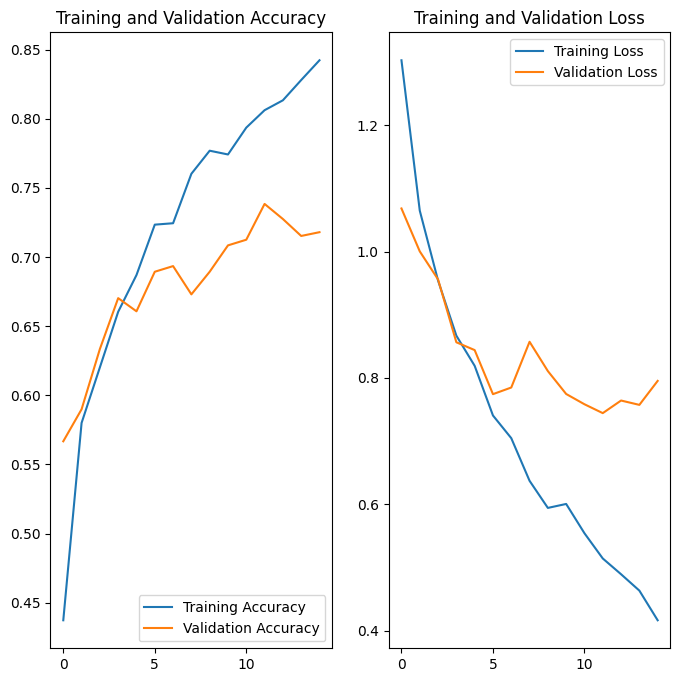

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


117948/117948 [==============================] - 0s 0us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 125ms/step


This image most likely belongs to sunflowers with a 97.33 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr2jwfqh7/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr2jwfqh7/assets


2022-12-14 02:30:14.950940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-14 02:30:14.950996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 97.33 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

1.4305115e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).